In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

DIR_PATH = '../data/suicide/'

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# /kaggle/input
for dirname, _, filenames in os.walk(DIR_PATH):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

../data/suicide/HDI.csv
../data/suicide/master.csv
../data/suicide/postUSSR_suicide.csv


In [2]:
df = pd.read_csv(os.path.join(DIR_PATH, 'master.csv'))
df.head()

,country,year,sex,age,suicides_no,population,suicides/100k pop,country-year,HDI for year,gdp_for_year ($),gdp_per_capita ($),generation
0,Albania,1987,male,15-24 years,21,312900,6.71,Albania1987,NaN,"2,156,624,900",796,Generation X
1,Albania,1987,male,35-54 years,16,308000,5.19,Albania1987,NaN,"2,156,624,900",796,Silent
2,Albania,1987,female,15-24 years,14,289700,4.83,Albania1987,NaN,"2,156,624,900",796,Generation X
3,Albania,1987,male,75+ years,1,21800,4.59,Albania1987,NaN,"2,156,624,900",796,G.I. Generation
4,Albania,1987,male,25-34 years,9,274300,3.28,Albania1987,NaN,"2,156,624,900",796,Boomers


### Проверка данных на пустоту

In [3]:
df.loc[df.country == 'Austria']

,country,year,sex,age,suicides_no,population,suicides/100k pop,country-year,HDI for year,gdp_for_year ($),gdp_per_capita ($),generation
1786,Austria,1985,male,75+ years,152,156535,97.10,Austria1985,0.764,"69,386,774,475",9759,G.I. Generation
1787,Austria,1985,male,55-74 years,355,584253,60.76,Austria1985,0.764,"69,386,774,475",9759,G.I. Generation
1788,Austria,1985,male,35-54 years,515,940526,54.76,Austria1985,0.764,"69,386,774,475",9759,Silent
1789,Austria,1985,male,25-34 years,232,548783,42.28,Austria1985,0.764,"69,386,774,475",9759,Boomers
1790,Austria,1985,female,75+ years,110,339223,32.43,Austria1985,0.764,"69,386,774,475",9759,G.I. Generation
...,...,...,...,...,...,...,...,...,...,...,...,...
2163,Austria,2016,male,15-24 years,58,525977,11.03,Austria2016,NaN,"390,799,991,147",46976,Millenials
2164,Austria,2016,female,55-74 years,99,1009403,9.81,Austria2016,NaN,"390,799,991,147",46976,Boomers
2165,Austria,2016,female,35-54 years,95,1273241,7.46,Austria2016,NaN,"390,799,991,147",46976,Generation X
2166,Austria,2016,female,15-24 years,22,488020,4.51,Austria2016,NaN,"390,799,991,147",46976,Millenials


In [4]:
df.rename(columns={ 
    'HDI for year': 'HDI', 
    ' gdp_for_year ($) ': 'gdp_year',
    'gdp_per_capita ($)': 'gdp_per_person'
}, inplace=True)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27820 entries, 0 to 27819
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   country            27820 non-null  object 
 1   year               27820 non-null  int64  
 2   sex                27820 non-null  object 
 3   age                27820 non-null  object 
 4   suicides_no        27820 non-null  int64  
 5   population         27820 non-null  int64  
 6   suicides/100k pop  27820 non-null  float64
 7   country-year       27820 non-null  object 
 8   HDI                8364 non-null   float64
 9   gdp_year           27820 non-null  object 
 10  gdp_per_person     27820 non-null  int64  
 11  generation         27820 non-null  object 
dtypes: float64(2), int64(4), object(6)
memory usage: 2.5+ MB


HDI имеет много NaN. HDI - уровень человеческого развития, на уровне страны.

Вообщем, HDI для некоторых(или для всех) стран, в старые времена, аля 1987 - не имеет рейтинга. Т.е. нужно либо разделить датасет на несколько, где есть HDI и где нет,
либо заполнить одним числом на страну, либо убрать вообще(что будет плохо, ибо это самый значимый параметр, имха)

Странно данные заполнены, для Албании, например, 1995 год имеет рейтинг для всех записей, а вот 1994 и 1996 - нет.
Если в других странах также - заполню ближайшими в рамках страны!
Это либо хитрый apply либо map применять. Просто .fillna - не подойдет, иначе он рейтингом Австрии заполнит Албанию.

In [6]:
# хочу посмотреть какие диапазоны годов у стран(т.е. у всех ли стран одни и те же года)
data_summary = df.groupby('country').agg(['max', 'min'])
data_summary

year         sex                age               \
                       max   min   max     min        max          min   
country                                                                  
Albania               2010  1987  male  female  75+ years  15-24 years   
Antigua and Barbuda   2015  1985  male  female  75+ years  15-24 years   
Argentina             2015  1985  male  female  75+ years  15-24 years   
Armenia               2016  1990  male  female  75+ years  15-24 years   
Aruba                 2011  1995  male  female  75+ years  15-24 years   
...                    ...   ...   ...     ...        ...          ...   
United Arab Emirates  2010  2005  male  female  75+ years  15-24 years   
United Kingdom        2015  1985  male  female  75+ years  15-24 years   
United States         2015  1985  male  female  75+ years  15-24 years   
Uruguay               2015  1985  male  female  75+ years  15-24 years   
Uzbekistan            2014  1990  male  female  75+ years  15-24 years   

                     suicides_no     population           ...  \
                             max min        max      min  ...   
country                                                   ...   
Albania                       39   0     394593    21800  ...   
Antigua and Barbuda            2   0      15323      424  ...   
Argentina                    745   7    5301368   363000  ...   
Armenia                       32   0     563626    26900  ...   
Aruba                          4   0      18313      889  ...   
...                          ...  ..        ...      ...  ...   
United Arab Emirates          52   0    2405804     5259  ...   
United Kingdom              1743   0    8881944  1202838  ...   
United States              11767  50   43805214  4064000  ...   
Uruguay                      152   0     440475    46900  ...   
Uzbekistan                   528   3    3620833    92400  ...   

                                  country-year                            \
                                           max                       min   
country                                                                    
Albania                            Albania2010               Albania1987   
Antigua and Barbuda    Antigua and Barbuda2015   Antigua and Barbuda1985   
Argentina                        Argentina2015             Argentina1985   
Armenia                            Armenia2016               Armenia1990   
Aruba                                Aruba2011                 Aruba1995   
...                                        ...                       ...   
United Arab Emirates  United Arab Emirates2010  United Arab Emirates2005   
United Kingdom              United Kingdom2015        United Kingdom1985   
United States                United States2015         United States1985   
Uruguay                            Uruguay2015               Uruguay1985   
Uzbekistan                      Uzbekistan2014            Uzbekistan1990   

                        HDI                  gdp_year                      \
                        max    min                max                 min   
country                                                                     
Albania               0.722  0.619      8,992,642,349       1,228,071,038   
Antigua and Barbuda   0.783  0.781        919,577,148       1,022,191,296   
Argentina             0.836  0.694     97,724,004,252     110,934,442,763   
Armenia               0.733  0.605      9,260,284,938       1,201,313,201   
Aruba                   NaN    NaN      2,791,960,894       1,320,670,391   
...                     ...    ...                ...                 ...   
United Arab Emirates  0.828  0.822    315,474,615,739     180,617,018,380   
United Kingdom        0.907  0.753    926,884,816,754   1,061,388,722,256   
United States         0.915  0.841  9,660,624,000,000  10,284,779,000,000   
Uruguay               0.793  0.667      9,298,839,655      12,045,631,093   
Uzbekist

In [7]:
# макс. год для страны(в данных)
top_years_by_country = data_summary['year']['max']
# страны перечисленные в датасете про самоубийства, по ним буду заполнять HDI
countries = df.country.unique()

In [8]:
# По какой то причине для некоторых стран последние года не заполнены для HDI - собственно
#загружу их из HDI данных и потом запущу backfill
HDI_data = pd.read_csv(os.path.join(DIR_PATH, 'HDI.csv'), index_col='Country')
HDI_data.head()

,HDI
Country,
Norway,0.957
Ireland,0.955
Switzerland,0.955
"Hong Kong, China (SAR)",0.949
Iceland,0.949


In [9]:
# правлю расхождения в названиях стран между датасетом и списком HDI
country_subs = {
    'Czechia': 'Czech Republic', 
    'Saint Vincent and the Grenadines': 'Saint Vincent and Grenadines'
}
HDI_data.rename(index=country_subs, inplace=True)

In [10]:
for country in HDI_data.index:
    if country in countries:
        year = top_years_by_country[country]
        df.loc[(df.country == country) & (df.year == year), 'HDI'] = HDI_data.loc[country, 'HDI']

Собственно заполнение всех HDI, если страна есть в HDI рейтинге вообще.

In [11]:
df.loc[(df.year == 2015) & (df.country=='Austria')]

,country,year,sex,age,suicides_no,population,suicides/100k pop,country-year,HDI,gdp_year,gdp_per_person,generation
2146,Austria,2015,male,75+ years,214,290329,73.71,Austria2015,NaN,"382,065,930,308",46484,Silent
2147,Austria,2015,male,55-74 years,294,915115,32.13,Austria2015,NaN,"382,065,930,308",46484,Boomers
2148,Austria,2015,male,35-54 years,313,1279822,24.46,Austria2015,NaN,"382,065,930,308",46484,Generation X
2149,Austria,2015,female,75+ years,70,461676,15.16,Austria2015,NaN,"382,065,930,308",46484,Silent
2150,Austria,2015,male,25-34 years,78,590968,13.20,Austria2015,NaN,"382,065,930,308",46484,Millenials
2151,Austria,2015,male,15-24 years,61,519646,11.74,Austria2015,NaN,"382,065,930,308",46484,Millenials
2152,Austria,2015,female,55-74 years,100,998854,10.01,Austria2015,NaN,"382,065,930,308",46484,Boomers
2153,Austria,2015,female,35-54 years,79,1273034,6.21,Austria2015,NaN,"382,065,930,308",46484,Generation X
2154,Austria,2015,female,15-24 years,19,490742,3.87,Austria2015,NaN,"382,065,930,308",46484,Millenials
2155,Austria,2015,female,25-34 years,21,576661,3.64,Austria2015,NaN,"382,065,930,308",46484,Millenials


In [12]:
for country in countries:
    filled_data = df.loc[df.country == country].HDI.fillna(method='bfill')
    df.loc[filled_data.index, 'HDI'] = filled_data

In [13]:
df.loc[(df.country == 'Austria') & df.year.isin([2015, 2016])]

,country,year,sex,age,suicides_no,population,suicides/100k pop,country-year,HDI,gdp_year,gdp_per_person,generation
2146,Austria,2015,male,75+ years,214,290329,73.71,Austria2015,0.922,"382,065,930,308",46484,Silent
2147,Austria,2015,male,55-74 years,294,915115,32.13,Austria2015,0.922,"382,065,930,308",46484,Boomers
2148,Austria,2015,male,35-54 years,313,1279822,24.46,Austria2015,0.922,"382,065,930,308",46484,Generation X
2149,Austria,2015,female,75+ years,70,461676,15.16,Austria2015,0.922,"382,065,930,308",46484,Silent
2150,Austria,2015,male,25-34 years,78,590968,13.20,Austria2015,0.922,"382,065,930,308",46484,Millenials
2151,Austria,2015,male,15-24 years,61,519646,11.74,Austria2015,0.922,"382,065,930,308",46484,Millenials
2152,Austria,2015,female,55-74 years,100,998854,10.01,Austria2015,0.922,"382,065,930,308",46484,Boomers
2153,Austria,2015,female,35-54 years,79,1273034,6.21,Austria2015,0.922,"382,065,930,308",46484,Generation X
2154,Austria,2015,female,15-24 years,19,490742,3.87,Austria2015,0.922,"382,065,930,308",46484,Millenials
2155,Austria,2015,female,25-34 years,21,576661,3.64,Austria2015,0.922,"382,065,930,308",46484,Millenials


Проверяем итоги заполнения данными по HDI

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27820 entries, 0 to 27819
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   country            27820 non-null  object 
 1   year               27820 non-null  int64  
 2   sex                27820 non-null  object 
 3   age                27820 non-null  object 
 4   suicides_no        27820 non-null  int64  
 5   population         27820 non-null  int64  
 6   suicides/100k pop  27820 non-null  float64
 7   country-year       27820 non-null  object 
 8   HDI                26860 non-null  float64
 9   gdp_year           27820 non-null  object 
 10  gdp_per_person     27820 non-null  int64  
 11  generation         27820 non-null  object 
dtypes: float64(2), int64(4), object(6)
memory usage: 2.5+ MB


Немного корявых данных осталось, примерно 27820 - 26826 ~~ 1к записей, что не много.
Если там будут просто страны без рейтинга - дешевле будет просто отрезать эти данные.

In [15]:
df_with_hdi_na = df.loc[df.HDI.isna()]
df_with_hdi_na

,country,year,sex,age,suicides_no,population,suicides/100k pop,country-year,HDI,gdp_year,gdp_per_person,generation
1258,Aruba,1995,male,75+ years,2,889,224.97,Aruba1995,NaN,"1,320,670,391",17949,G.I. Generation
1259,Aruba,1995,male,25-34 years,4,7520,53.19,Aruba1995,NaN,"1,320,670,391",17949,Generation X
1260,Aruba,1995,male,55-74 years,1,4558,21.94,Aruba1995,NaN,"1,320,670,391",17949,Silent
1261,Aruba,1995,male,35-54 years,1,11895,8.41,Aruba1995,NaN,"1,320,670,391",17949,Boomers
1262,Aruba,1995,female,15-24 years,0,5138,0.00,Aruba1995,NaN,"1,320,670,391",17949,Generation X
...,...,...,...,...,...,...,...,...,...,...,...,...
21963,San Marino,2005,male,15-24 years,0,1440,0.00,San Marino2005,NaN,"1,958,711,603",69301,Millenials
21964,San Marino,2005,male,25-34 years,0,2176,0.00,San Marino2005,NaN,"1,958,711,603",69301,Generation X
21965,San Marino,2005,male,35-54 years,0,4793,0.00,San Marino2005,NaN,"1,958,711,603",69301,Boomers
21966,San Marino,2005,male,5-14 years,0,1545,0.00,San Marino2005,NaN,"1,958,711,603",69301,Millenials


In [16]:
df_with_hdi_na.groupby('country').agg(['min', 'max'])

year           sex                age             \
                    min   max     min   max          min        max   
country                                                               
Aruba              1995  2011  female  male  15-24 years  75+ years   
Macau              1994  1994  female  male  15-24 years  75+ years   
Puerto Rico        1985  2015  female  male  15-24 years  75+ years   
Republic of Korea  1985  2015  female  male  15-24 years  75+ years   
San Marino         1999  2005  female  male  15-24 years  75+ years   

                  suicides_no       population           ...  \
                          min   max        min      max  ...   
country                                                  ...   
Aruba                       0     4        889    18313  ...   
Macau                       0     6       3622    55677  ...   
Puerto Rico                 0   127      46600   523033  ...   
Republic of Korea           8  4255     154800  8696946  ...   
San Marino                  0     1        721     4856  ...   

                            country-year                        HDI      \
                                     min                    max min max   
country                                                                   
Aruba                          Aruba1995              Aruba2011 NaN NaN   
Macau                          Macau1994              Macau1994 NaN NaN   
Puerto Rico              Puerto Rico1985        Puerto Rico2015 NaN NaN   
Republic of Korea  Republic of Korea1985  Republic of Korea2015 NaN NaN   
San Marino                San Marino1999         San Marino2005 NaN NaN   

                            gdp_year                  gdp_per_person         \
                                 min              max            min    max   
country                                                                       
Aruba                  1,320,670,391    2,791,960,894          17949  29447   
Macau                  6,265,844,252    6,265,844,252          18081  18081   
Puerto Rico          100,351,670,000   98,381,268,000           6582  29728   
Republic of Korea  1,002,219,052,968  901,934,953,365           2731  29120   
San Marino             1,101,897,918    1,958,711,603          43435  69301   

                  generation          
                         min     max  
country                               
Aruba                Boomers  Silent  
Macau                Boomers  Silent  
Puerto Rico          Boomers  Silent  
Republic of Korea    Boomers  Silent  
San Marino           Boomers  Silent  

[5 rows x 22 columns]

По итогу, не записались Чехия и Сент Винсент, из HDI не взялось т.к. названия расходились в датасете и в моем HDI списке. Правку поднял к инициализации.

Остальные данные удаляю, т.к. итак данных достаточно много.

In [17]:
# Подчищаю "лишние" данные
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26860 entries, 0 to 27819
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   country            26860 non-null  object 
 1   year               26860 non-null  int64  
 2   sex                26860 non-null  object 
 3   age                26860 non-null  object 
 4   suicides_no        26860 non-null  int64  
 5   population         26860 non-null  int64  
 6   suicides/100k pop  26860 non-null  float64
 7   country-year       26860 non-null  object 
 8   HDI                26860 non-null  float64
 9   gdp_year           26860 non-null  object 
 10  gdp_per_person     26860 non-null  int64  
 11  generation         26860 non-null  object 
dtypes: float64(2), int64(4), object(6)
memory usage: 2.7+ MB


Ну вотс, с этими данными уже можно работать, т.е. проводить по ним EDA.

In [18]:
#df.to_csv('suicide.csv')

По хорошему использовать сохраненную версию файла, но тогда придется удалить или как то обернуть все ранее написанное, а не хотелось бы.

Так что пусть каждый раз делает проверку ._. (По крайней мере сейчас)

## EDA
Попробую заодно и матплотлиб и сеаборн

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

В целом смотрю на данные(уже частично сделал это когда группировал их)

In [20]:
# описание числовых данных
df.describe(include=[np.number])

,year,suicides_no,population,suicides/100k pop,HDI,gdp_per_person
count,26860.000000,26860.000000,2.686000e+04,26860.000000,26860.000000,26860.000000
mean,2001.277439,241.158414,1.856297e+06,12.713709,0.768877,16778.618317
std,8.474394,910.525386,3.961020e+06,18.656791,0.093334,19112.409966
min,1985.000000,0.000000,2.780000e+02,0.000000,0.483000,251.000000
25%,1995.000000,3.000000,9.790000e+04,0.940000,0.697000,3361.000000
50%,2002.000000,25.000000,4.371580e+05,5.960000,0.775000,8906.000000
75%,2009.000000,130.000000,1.459776e+06,16.430000,0.848000,24697.000000
max,2016.000000,22338.000000,4.380521e+07,204.920000,0.957000,126352.000000


suicides_no и suicides/100k - одна и та же величина, которую при использовании в моделях - нужно будет оставить в одной колонке.

В целом, даже самое большое количество самоубийств - 1 из 5000, за год, не так уж много впринципе.
Причем, в большинстве стран(не менее 75%) - количество самоубийц - 16.5 на 100к за год, т.е. очень мало.
И это с учетом 90х, которые страны бывшего советского союза, например, прожили особенно тяжело.
________
ЗЫ. Это не совсем 1 из 5000 за год в стране, это в конкретной возрастной категории х) Из 12 вариантов примерно. Т.е. цифры на самом деле могут быть лютые.

**Вопросы:**
1. Было бы интересно посмотреть сколько реально самовыпилилось в странах за год, т.е. сгруппировать и агрегировать суммой.
2. А еще, интересно как было с самоубийствами в странах бывшего СССР с 1988 по 1995 примерно, мб до 2000х.

In [21]:
# описание не числовых данных(категории и т.п.)
df.describe(include=[object])

,country,sex,age,country-year,gdp_year,generation
count,26860,26860,26860,26860,26860,26860
unique,96,2,6,2241,2241,6
top,Mauritius,male,15-24 years,Albania1987,"2,156,624,900",Generation X
freq,382,13430,4482,12,12,6184


GDP for year в какой то дурацкой форме записан, строкой. GDP - внутр. валовый продукт(ВВП).
Видимо, что бы было понятно масштаб числа.
**Сделать:**
1. Перевести gdp в число
2. Проверить корреляцию между GDP и HDI, а также GDP и самоубийствами.
3. (Возможно) И есть ли смысл в gdp, если есть HDI? Если нет - то удалю gdp.
4. Можно посмотреть, кто охотнее выпиливается из поколений. (чувствую, что поколен Х - рекордсмены)
5. Аналогично и по возрастам

1. Сколько выпилилось людей за год в мире:

In [22]:
suicide_per_year = df.groupby('year').agg({ 'suicides_no': ['sum', 'count', 'mean']})
suicide_per_year

suicides_no                  
             sum count        mean
year                              
1985      112105   552  203.088768
1986      116902   552  211.778986
1987      123269   624  197.546474
1988      117763   564  208.799645
1989      156894   600  261.490000
1990      189831   744  255.149194
1991      194596   744  261.553763
1992      207626   756  274.637566
1993      217096   756  287.164021
1994      227469   780  291.626923
1995      238406   900  264.895556
1996      240537   900  267.263333
1997      234448   900  260.497778
1998      240701   924  260.498918
1999      248744   948  262.388186
2000      249072   984  253.121951
2001      243448  1020  238.674510
2002      247236   996  248.228916
2003      244917   996  245.900602
2004      229082   972  235.681070
2005      222064   960  231.316667
2006      222434   984  226.050813
2007      220955   996  221.842369
2008      222285   984  225.899390
2009      227751  1032  220.688953
2010      222851  1020  218.481373
2011      220311   996  221.195783
2012      215753   948  227.587553
2013      208532   936  222.790598
2014      208930   912  229.089912
2015      189904   720  263.755556
2016       15603   160   97.518750

Выше представлена группировка суммой по самоубийствам и количествам строк, из которых эта сумма была получена. Как видно, в 1985 году данных было представлено в 2 раза меньше, чем в 2000, например. А значит, нельзя говорить, что количество самоубийств как то изменилось, ибо данные неоднородны.

Аналогично и с характеристикой средней, вполне могли добавиться к рейтингу неблагополучные страны, где самоубийство не считается чем то шокирующим.

И это касается всего исследования, нужно разделить страны по благополучным и неблагополучным, по какой то отсечке.

Можно также проверить наполненность данных, т.е. какие года наиболее снабжены информацией, а какие наименее

2\. Страны отраженные в рейтинге:

In [23]:
df.country.unique()

array(['Albania', 'Antigua and Barbuda', 'Argentina', 'Armenia',
       'Australia', 'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain',
       'Barbados', 'Belarus', 'Belgium', 'Belize',
       'Bosnia and Herzegovina', 'Brazil', 'Bulgaria', 'Cabo Verde',
       'Canada', 'Chile', 'Colombia', 'Costa Rica', 'Croatia', 'Cuba',
       'Cyprus', 'Czech Republic', 'Denmark', 'Dominica', 'Ecuador',
       'El Salvador', 'Estonia', 'Fiji', 'Finland', 'France', 'Georgia',
       'Germany', 'Greece', 'Grenada', 'Guatemala', 'Guyana', 'Hungary',
       'Iceland', 'Ireland', 'Israel', 'Italy', 'Jamaica', 'Japan',
       'Kazakhstan', 'Kiribati', 'Kuwait', 'Kyrgyzstan', 'Latvia',
       'Lithuania', 'Luxembourg', 'Maldives', 'Malta', 'Mauritius',
       'Mexico', 'Mongolia', 'Montenegro', 'Netherlands', 'New Zealand',
       'Nicaragua', 'Norway', 'Oman', 'Panama', 'Paraguay', 'Philippines',
       'Poland', 'Portugal', 'Qatar', 'Romania', 'Russian Federation',
       'Saint Kitts and Nevis', 'Saint L

3\. Полнота данных по странам бывшего СССР.

In [24]:
postUSSR = ['Azerbaijan', 'Armenia', 'Belarus', 'Kazakhstan', 'Kyrgyzstan', 'Latvia', 
            'Russian Federation', 'Estonia', 'Uzbekistan', 'Ukraine', 'Turkmenistan',
            'Georgia']
df_postUSSR = df.loc[df.country.isin(postUSSR)]
df_postUSSR.tail()

,country,year,sex,age,suicides_no,population,suicides/100k pop,country-year,HDI,gdp_year,gdp_per_person,generation
27815,Uzbekistan,2014,female,35-54 years,107,3620833,2.96,Uzbekistan2014,0.72,"63,067,077,179",2309,Generation X
27816,Uzbekistan,2014,female,75+ years,9,348465,2.58,Uzbekistan2014,0.72,"63,067,077,179",2309,Silent
27817,Uzbekistan,2014,male,5-14 years,60,2762158,2.17,Uzbekistan2014,0.72,"63,067,077,179",2309,Generation Z
27818,Uzbekistan,2014,female,5-14 years,44,2631600,1.67,Uzbekistan2014,0.72,"63,067,077,179",2309,Generation Z
27819,Uzbekistan,2014,female,55-74 years,21,1438935,1.46,Uzbekistan2014,0.72,"63,067,077,179",2309,Boomers


In [25]:
df_postUSSR.country.value_counts()

Turkmenistan          348
Ukraine               336
Russian Federation    324
Kazakhstan            312
Kyrgyzstan            312
Armenia               298
Georgia               264
Uzbekistan            264
Belarus               252
Estonia               252
Latvia                252
Azerbaijan            192
Name: country, dtype: int64

Как видно, данные опять отличаются по количеству, для разных стран ._. Доколе

Интересно хотя бы за какие года, в этот раз гистограммой, чтобы понять, можно ли сердцевинку взять по годам. Хотя толку? Если во всей куче данные по году N будут у почти всех, а у одной страны, наоборот, отсутствовать.

In [26]:
df_postUSSR.groupby('country').agg({'year': ['count', 'min', 'max', pd.Series.nunique, lambda x: max(x) - min(x)]})

year                               
                   count   min   max nunique <lambda_0>
country                                                
Armenia              298  1990  2016      25         26
Azerbaijan           192  1990  2007      16         17
Belarus              252  1990  2014      21         24
Estonia              252  1995  2015      21         20
Georgia              264  1990  2015      22         25
Kazakhstan           312  1990  2015      26         25
Kyrgyzstan           312  1990  2015      26         25
Latvia               252  1995  2015      21         20
Russian Federation   324  1989  2015      27         26
Turkmenistan         348  1987  2015      29         28
Ukraine              336  1987  2015      28         28
Uzbekistan           264  1990  2014      22         24

У большинства стран есть участок с 90х до 2000 - вполне себе интересный участок.
1) Латвию и Эстонию придется убрать для исследования 1990-2000, ибо там данные с 1995 года. 

2) Азербайджан придется убрать для исследования 2000-2014.

In [27]:
df_postUSSR_90_00 = df_postUSSR.loc[
    (~df_postUSSR.country.isin(['Latvia', 'Estonia'])) 
     & (df_postUSSR.year >= 1990) 
     & (df_postUSSR.year <= 2000)]

In [28]:
df_postUSSR_00_14 = df_postUSSR.loc[
    (df_postUSSR.country != 'Azerbaijan') 
    & (df_postUSSR.year >= 2000) 
    & (df_postUSSR.year <= 2014)]

Проверяю, что данные теперь однородны в обоих кусках датасета

Датасет 1990-2000:

In [29]:
df_postUSSR_90_00.groupby('country').agg({'year': ['count', 'min', 'max', pd.Series.nunique, lambda x: max(x) - min(x)]})

year                               
                   count   min   max nunique <lambda_0>
country                                                
Armenia              132  1990  2000      11         10
Azerbaijan           132  1990  2000      11         10
Belarus              132  1990  2000      11         10
Georgia              120  1990  2000      10         10
Kazakhstan           132  1990  2000      11         10
Kyrgyzstan           132  1990  2000      11         10
Russian Federation   132  1990  2000      11         10
Turkmenistan         132  1990  2000      11         10
Ukraine              132  1990  2000      11         10
Uzbekistan           132  1990  2000      11         10

В джорджии не хватает какого то из годов :'c

Заполню по соседнему году, пусть это и немного халтура

In [30]:
df_postUSSR_90_00[df_postUSSR_90_00.country == 'Georgia'].year.unique()

array([1990, 1991, 1992, 1994, 1995, 1996, 1997, 1998, 1999, 2000],
      dtype=int64)

Пропущен 1993 год, сделаю как среднее 1992-1994годов

In [31]:
georgia_92_94 = df_postUSSR_90_00[
    (df_postUSSR_90_00.country == 'Georgia') & (df_postUSSR_90_00.year.isin([1992, 1994]))] \
.groupby(['country', 'age', 'sex', 'generation']).mean()


In [32]:
get_gdp_number = lambda x: int(''.join(x.split(',')))
num_format = "{:,}".format # для перевода в формат 3,002,111

georgia_93 = georgia_92_94.reset_index()
georgia_93['year'] = 1993
georgia_93.suicides_no = round(georgia_93.suicides_no)
gdp_year_number = df[(df.country == 'Georgia') & (df.year.isin([1992, 1994]))] \
    .gdp_year.apply(get_gdp_number).mean()
georgia_93['gdp_year'] = num_format(int(gdp_year_number))
georgia_93['country-year'] = georgia_93.country + georgia_93.year.astype('string')
georgia_93 = georgia_93.astype({
    'suicides_no': 'int64', 'population': 'int64', 'gdp_per_person': 'int64'})
georgia_93

,country,age,sex,generation,year,suicides_no,population,suicides/100k pop,HDI,gdp_per_person,gdp_year,country-year
0,Georgia,15-24 years,female,Generation X,1993,6,395825,1.350,0.672,648,"3,102,099,775",Georgia1993
1,Georgia,15-24 years,male,Generation X,1993,16,401475,4.100,0.672,648,"3,102,099,775",Georgia1993
2,Georgia,25-34 years,female,Boomers,1993,5,411425,1.175,0.672,648,"3,102,099,775",Georgia1993
3,Georgia,25-34 years,male,Boomers,1993,20,385325,4.975,0.672,648,"3,102,099,775",Georgia1993
4,Georgia,35-54 years,female,Boomers,1993,11,664875,1.645,0.672,648,"3,102,099,775",Georgia1993
5,Georgia,35-54 years,male,Boomers,1993,34,594825,5.530,0.672,648,"3,102,099,775",Georgia1993
6,Georgia,5-14 years,female,Millenials,1993,0,400200,0.000,0.672,648,"3,102,099,775",Georgia1993
7,Georgia,5-14 years,male,Millenials,1993,0,415650,0.000,0.672,648,"3,102,099,775",Georgia1993
8,Georgia,55-74 years,female,Silent,1993,15,513525,2.915,0.672,648,"3,102,099,775",Georgia1993
9,Georgia,55-74 years,male,Silent,1993,44,376950,11.775,0.672,648,"3,102,099,775",Georgia1993


In [33]:
df_postUSSR_90_00 = pd.concat([df_postUSSR_90_00, georgia_93]).reset_index()

Еще раз проверяю датасет 1990-2000, что в нем все данные есть:

In [34]:
df_postUSSR_90_00.groupby('country').agg({'year': ['count', 'min', 'max', pd.Series.nunique, lambda x: max(x) - min(x)]})

year                               
                   count   min   max nunique <lambda_0>
country                                                
Armenia              132  1990  2000      11         10
Azerbaijan           132  1990  2000      11         10
Belarus              132  1990  2000      11         10
Georgia              132  1990  2000      11         10
Kazakhstan           132  1990  2000      11         10
Kyrgyzstan           132  1990  2000      11         10
Russian Federation   132  1990  2000      11         10
Turkmenistan         132  1990  2000      11         10
Ukraine              132  1990  2000      11         10
Uzbekistan           132  1990  2000      11         10

Теперь норм!

In [35]:
df_postUSSR_90_00.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1320 entries, 0 to 1319
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   index              1320 non-null   int64  
 1   country            1320 non-null   object 
 2   year               1320 non-null   int64  
 3   sex                1320 non-null   object 
 4   age                1320 non-null   object 
 5   suicides_no        1320 non-null   int64  
 6   population         1320 non-null   int64  
 7   suicides/100k pop  1320 non-null   float64
 8   country-year       1320 non-null   object 
 9   HDI                1320 non-null   float64
 10  gdp_year           1320 non-null   object 
 11  gdp_per_person     1320 non-null   int64  
 12  generation         1320 non-null   object 
dtypes: float64(2), int64(5), object(6)
memory usage: 134.2+ KB


## Вопросы для исследования:
1. Было бы интересно посмотреть сколько реально самовыпилилось в каждой стране за год, т.е. сгруппировать и агрегировать суммой.  

Выведу Hbar

In [36]:
suicide_by_country = df_postUSSR_90_00.groupby('country').suicides_no.sum() \
    .sort_values(ascending=False)
suicide_by_country

country
Russian Federation    579414
Ukraine               147529
Kazakhstan             44506
Belarus                33508
Uzbekistan             17042
Kyrgyzstan              5881
Turkmenistan            3406
Georgia                 1803
Armenia                  962
Azerbaijan               955
Name: suicides_no, dtype: int64

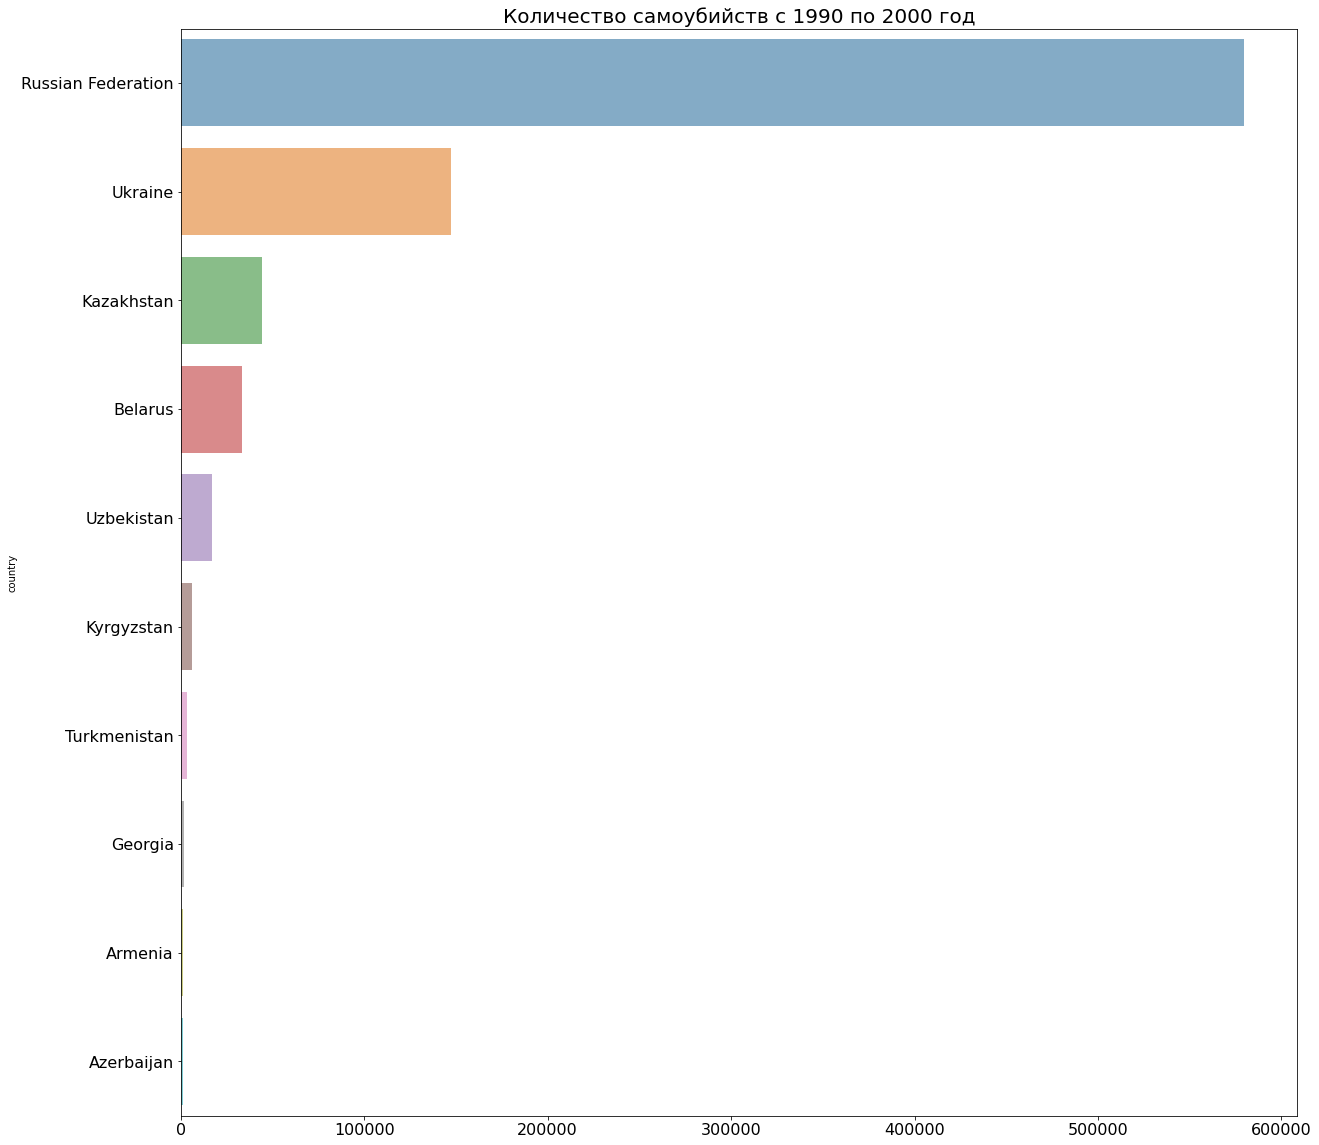

In [37]:
plt.figure(figsize=(20, 20))
plt.title('Количество самоубийств с 1990 по 2000 год', fontsize=20)
plt.tick_params(labelsize=16)
sns.barplot(y=suicide_by_country.index, x=suicide_by_country.values, alpha=0.6)
plt.show()

Какие категории возрастов для каждой страны самоубивались чаще всего. (Гистограмма)

In [38]:
suicide_country_age = df_postUSSR_90_00.groupby(['country', 'age']).suicides_no.sum() \
    .sort_values(ascending=False).reset_index()
suicide_country_age.head()

,country,age,suicides_no
0,Russian Federation,35-54 years,236701
1,Russian Federation,55-74 years,139674
2,Russian Federation,25-34 years,104443
3,Russian Federation,15-24 years,64114
4,Ukraine,35-54 years,58443


Еще вопросы по "сколько выпиливалось мужского\женского населения в каждой стране", через красивый барплот из 2го урока.

И в какой год выпилось больше всего(это сделать через пирог, в целом по всем странам)

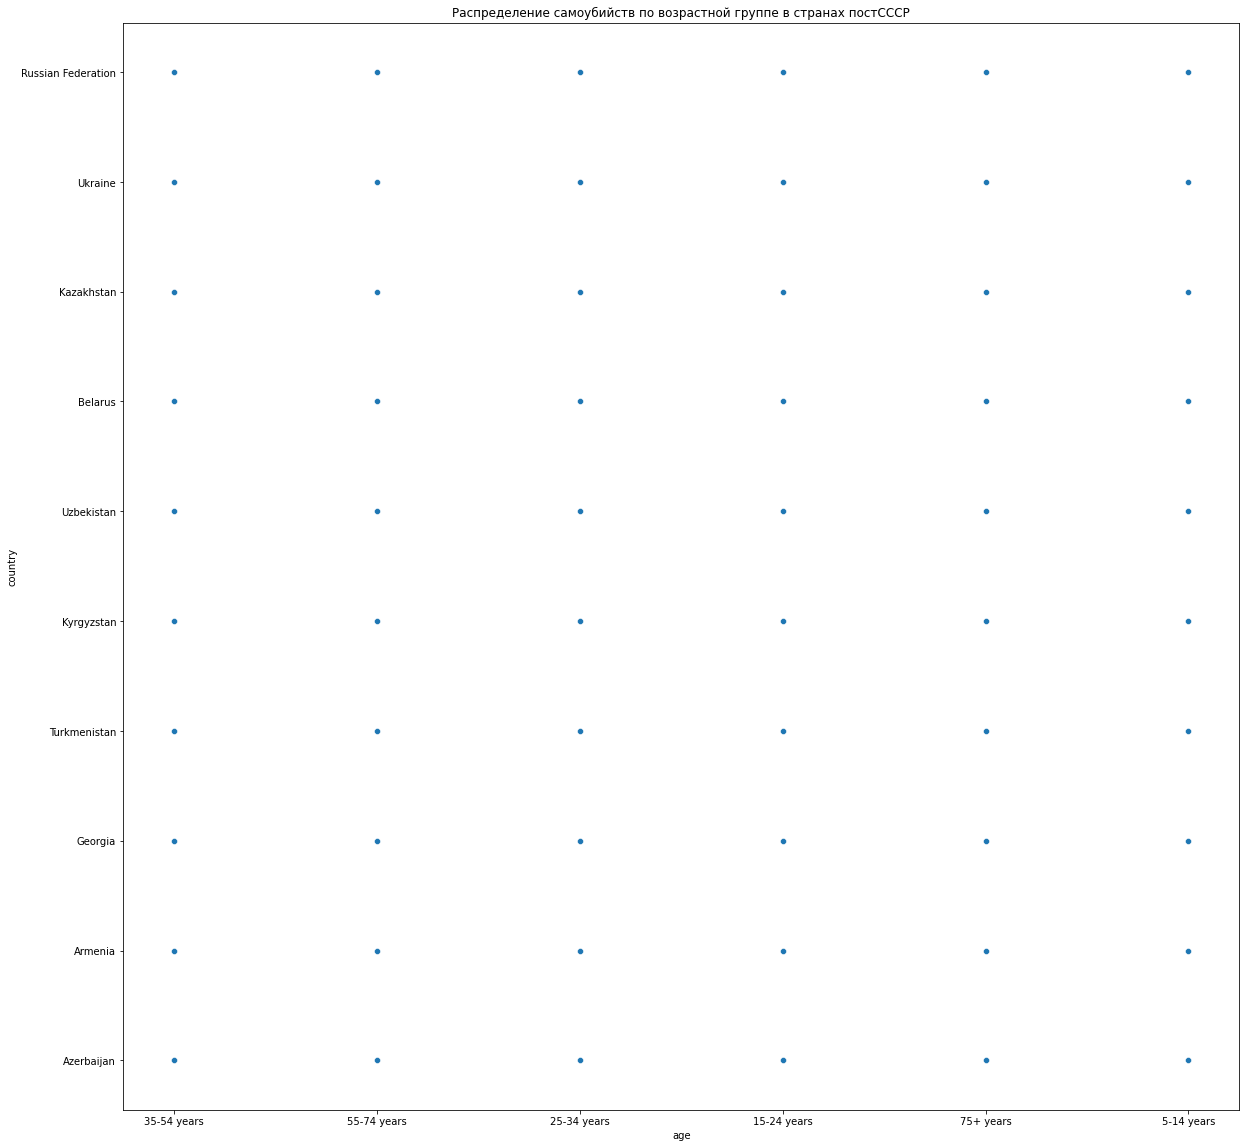

In [39]:
plt.figure(figsize=(20, 20))
plt.title('Распределение самоубийств по возрастной группе в странах постСССР')
sns.scatterplot(data=suicide_country_age, x='age', y='country')
plt.show()

Херня получилась х)

Вопрос: "сколько выпиливалось мужского\женского населения в каждой стране", через красивый барплот из 2го урока.

In [40]:
suicide_country_sex = df_postUSSR_90_00.groupby(['country', 'sex']).suicides_no.sum() \
    .sort_values().reset_index()
suicide_country_sex.head()

,country,sex,suicides_no
0,Azerbaijan,female,232
1,Armenia,female,269
2,Georgia,female,441
3,Armenia,male,693
4,Azerbaijan,male,723


In [41]:
suicide_country_sex = suicide_country_sex.set_index(['country', 'sex']).unstack('sex')
suicide_country_sex

suicides_no        
sex                     female    male
country                               
Armenia                    269     693
Azerbaijan                 232     723
Belarus                   5649   27859
Georgia                    441    1362
Kazakhstan                8345   36161
Kyrgyzstan                1191    4690
Russian Federation      104606  474808
Turkmenistan               821    2585
Ukraine                  28885  118644
Uzbekistan                4143   12899

In [42]:
def get_percentage(x):
    total = x.sum()
    x.loc['suicides_no', 'female'] = (x.loc['suicides_no', 'female'] / total) * 100
    x.loc['suicides_no', 'male'] = (x.loc['suicides_no', 'male'] / total) * 100
    return x

suicide_country_sex = suicide_country_sex.apply(get_percentage, axis=1)

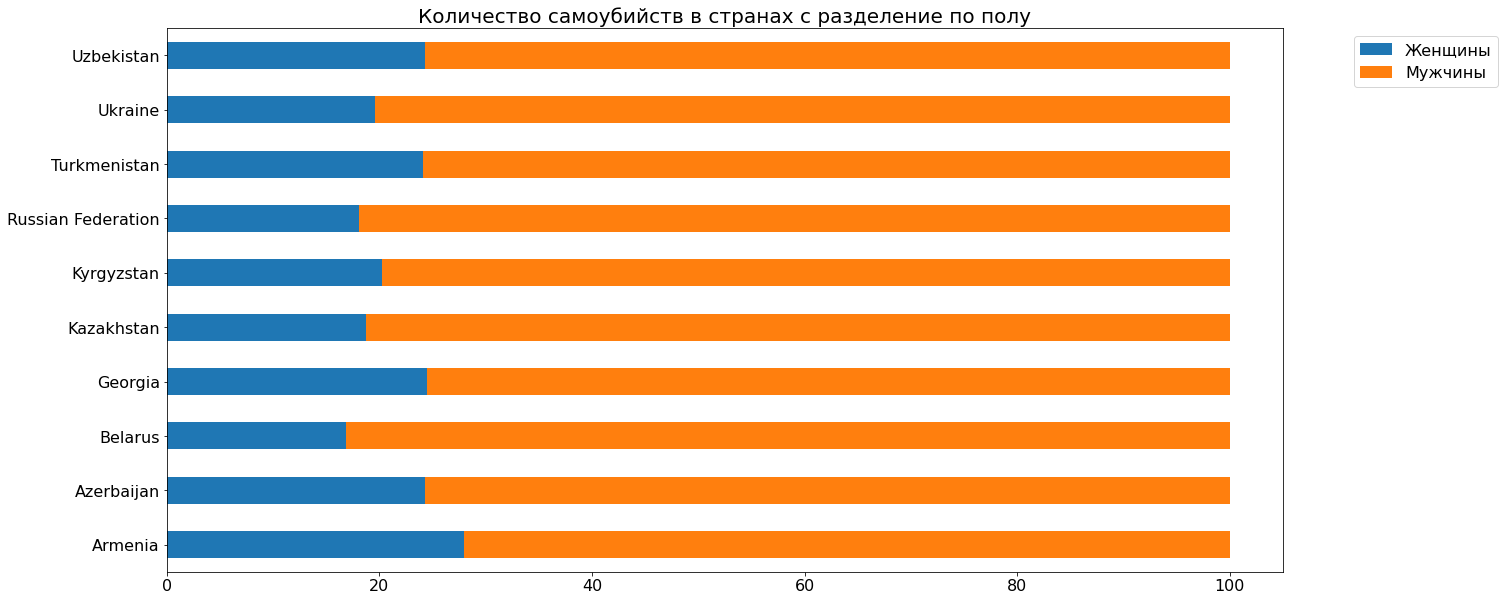

In [43]:
plot = suicide_country_sex.plot.barh(
    figsize=(20, 10),
    fontsize=16,
    stacked=True,
    title='Количество самоубийств в странах с разделение по полу'
)
plot.title.set_size(20)
plot.legend(['Женщины', 'Мужчины'], loc=1, bbox_to_anchor=(1.2, 1), fontsize=16)
plot.set(ylabel=None, xlabel=None)
plt.show()

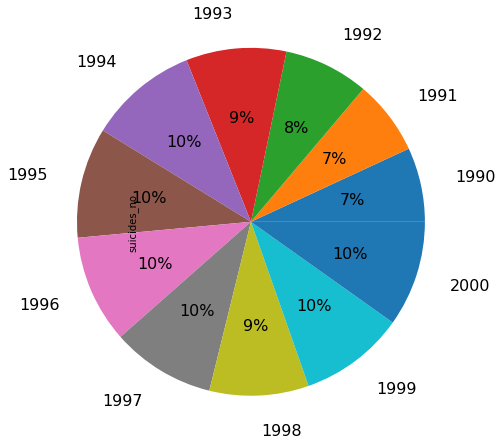

In [44]:
suicide_by_year = df_postUSSR_90_00.groupby('year').suicides_no.sum()
suicide_by_year.plot.pie(autopct='%1.0f%%', radius=2, labeldistance=1.2, fontsize=16)
plt.show()

Сделать множественный гориз. бар для стран->возраста

In [45]:
suicides_country_age = df_postUSSR_90_00.groupby(['country', 'age']).suicides_no.sum() \
    .reset_index()
suicides_country_age.head()

,country,age,suicides_no
0,Armenia,15-24 years,87
1,Armenia,25-34 years,175
2,Armenia,35-54 years,334
3,Armenia,5-14 years,8
4,Armenia,55-74 years,297


In [46]:
suicides_country_age.country.unique()

array(['Armenia', 'Azerbaijan', 'Belarus', 'Georgia', 'Kazakhstan',
       'Kyrgyzstan', 'Russian Federation', 'Turkmenistan', 'Ukraine',
       'Uzbekistan'], dtype=object)

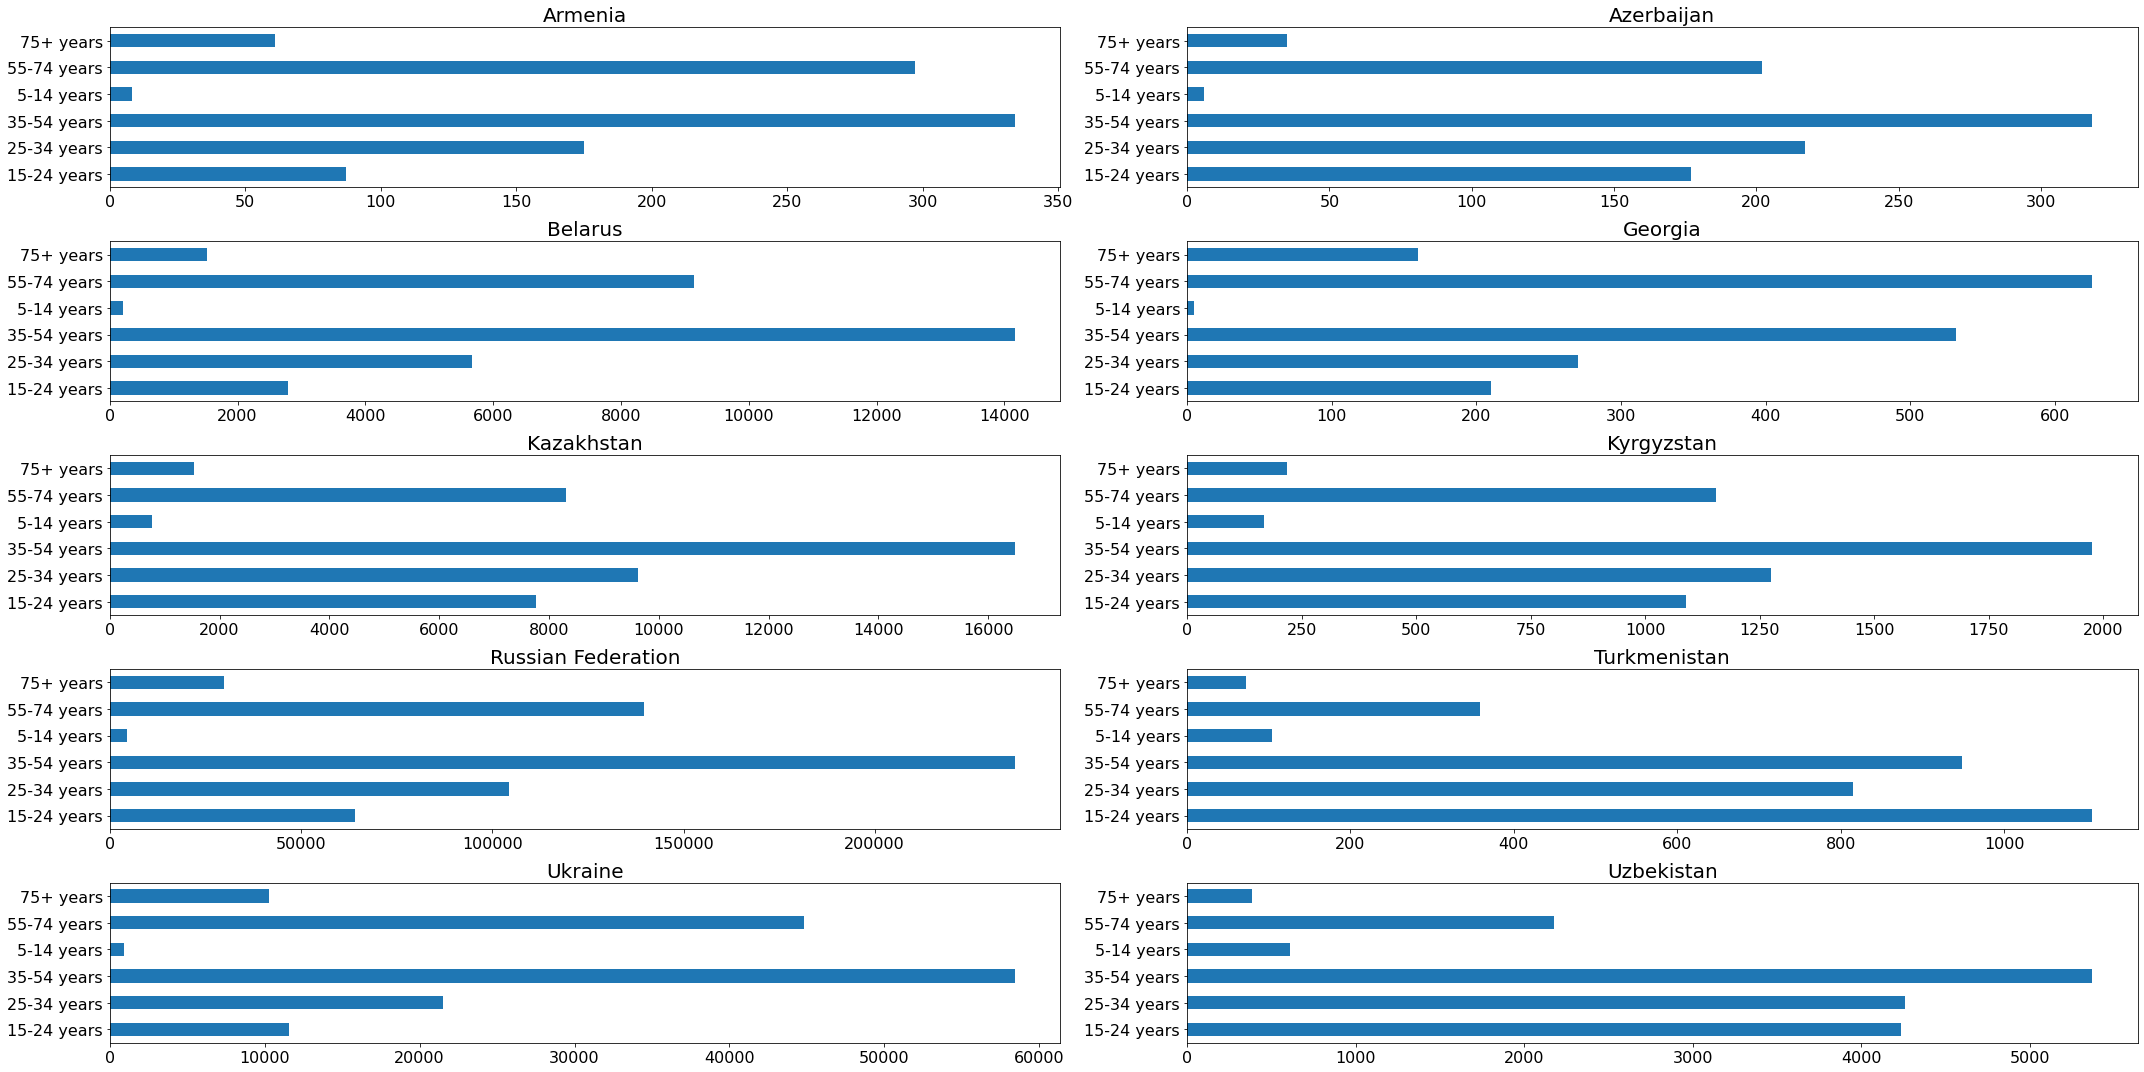

In [47]:
fig, axes = plt.subplots(5, 2, sharex=False, squeeze=False, figsize=(30, 15))

for ax, q in zip(axes.ravel(), suicides_country_age.country.unique()):
    tmp_df = suicides_country_age[suicides_country_age.country.eq(q)]
    ax.set_title(q, fontsize=20)
    ax.yaxis.label.set_visible(False)
    plt.tight_layout()
    
    tmp_df.plot.barh(x='age', fontsize=16, ax=ax, legend=None)

Можно посмотреть, кто охотнее выпиливается из поколений. (чувствую, что поколен Х - рекордсмены)


In [48]:
suicide_gen = df_postUSSR_90_00.groupby('generation').suicides_no.sum() \
    .sort_values(ascending=False)
suicide_gen

generation
Boomers            378010
Silent             215069
Generation X       177052
G.I. Generation     57982
Millenials           6893
Name: suicides_no, dtype: int64

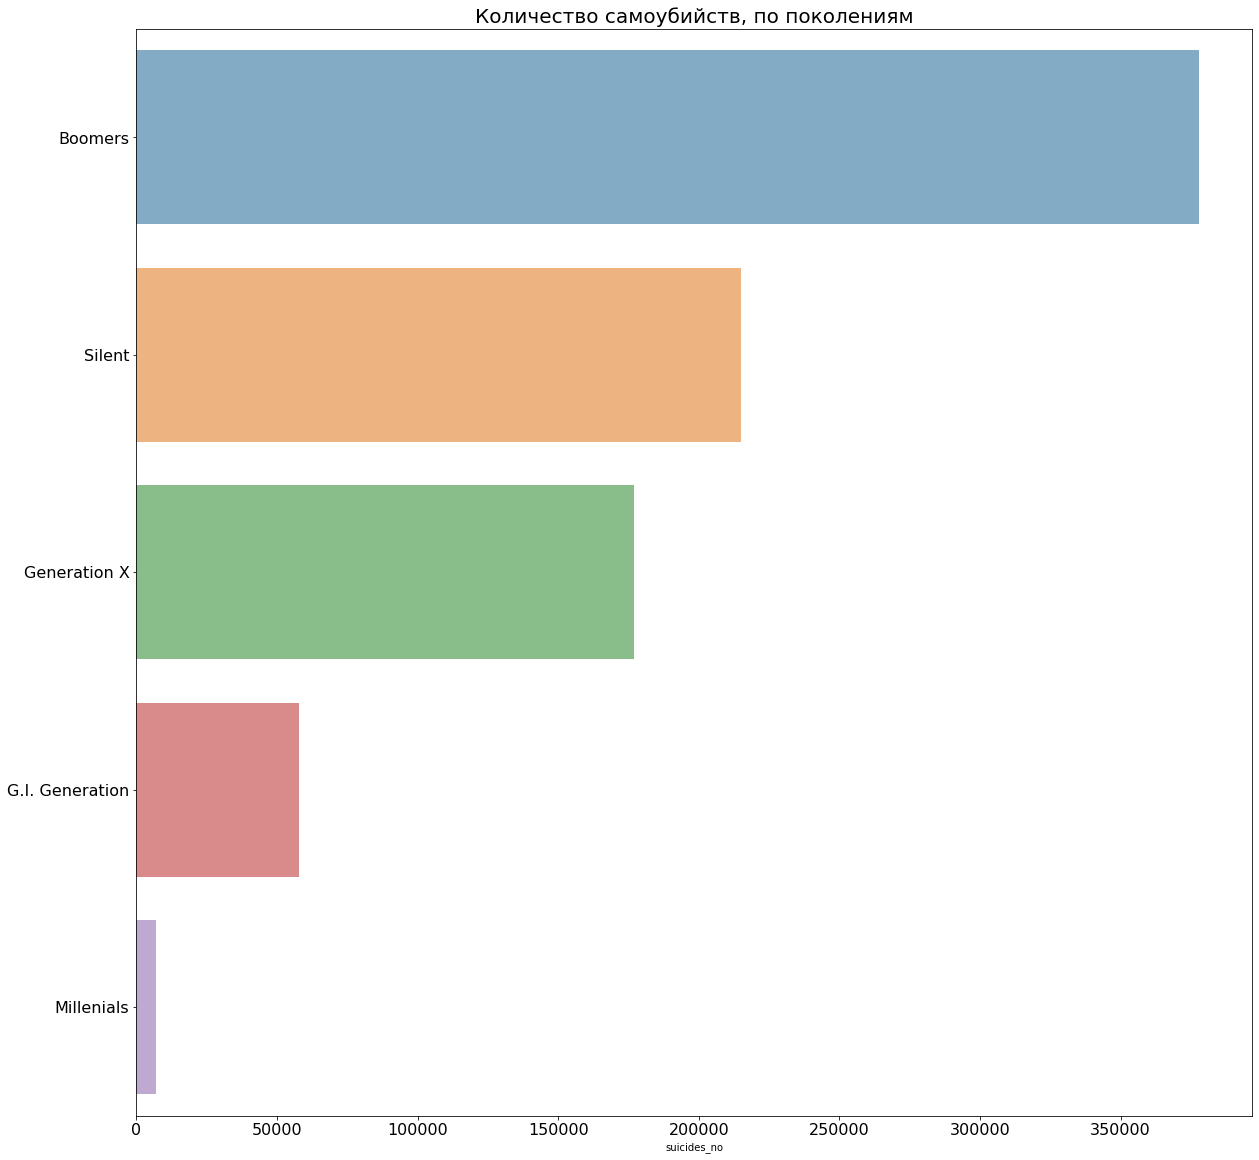

In [49]:
plt.figure(figsize=(20, 20))
plt.title('Количество самоубийств, по поколениям', fontsize=20)
plt.tick_params(labelsize=16)
sns.barplot(y=suicide_gen.index.values, x=suicide_gen, alpha=0.6)
plt.show()

Поколение Silent, хоть и было редким(война, некогда плодиться) - неплохо то самовыпиливались.

Что бумеры себя резали в больших количествах в 90ые - неудивительно. Из рая в ад. Их и много было, чо не плодиться то.

Х-сы тоже неплохо себя резали, ибо нахуй так жить.

А вот Великое поколение(те, кто воевал собсно) - почти не убивались. Хотя мб осталось их мало к 90м.

### С 2000 по 2014, постСССР
#### Проверка и подготовка сета

In [50]:
tmpdf_country_year = df_postUSSR_00_14.groupby(['country', 'year']).size().reset_index()
tmpdf_country_year

,country,year,0
0,Armenia,2000,12
1,Armenia,2001,12
2,Armenia,2002,12
3,Armenia,2003,12
4,Armenia,2006,12
...,...,...,...
147,Uzbekistan,2010,12
148,Uzbekistan,2011,12
149,Uzbekistan,2012,12
150,Uzbekistan,2013,12


In [51]:
years = set(tmpdf_country_year.year.unique())
countries = tmpdf_country_year.country.unique()
for country in countries:
    country_year_set = set(tmpdf_country_year.loc[tmpdf_country_year.country.eq(country)] \
        .year.tolist())
    missing_years = years.difference(country_year_set)
    if missing_years:
        print(f'Для страны {country} отсутствуют года: {missing_years}', )

Для страны Armenia отсутствуют года: {2004, 2005}
Для страны Belarus отсутствуют года: {2012, 2004, 2005, 2006}
Для страны Georgia отсутствуют года: {2008, 2002, 2003}
Для страны Ukraine отсутствуют года: {2013}
Для страны Uzbekistan отсутствуют года: {2008, 2006, 2007}


Опять пропущена часть годов: Узбекистан, Украина, Грузия, Беларусь, Армения

#### Функция, что будет заполнять пропущенные года в датасете, на основе ближайших

In [52]:
# Для обработки ситуаций, где на один возраст и разные года - разные поколения
# Внутри функции преобразую классиф. перемену в ранговую
gen_ranks = [ 'G.I. Generation', 'Silent', 'Boomers', 
             'Generation X', 'Millenials', 'Generation Z']

gen_ranks.index('Boomers')

2

In [53]:
def find_closest_number(operation, s_list, x):
    if operation == 'lt':
        for s_number in s_list[::-1]:
            if s_number < x:
                return s_number
    elif operation == 'gt':
        for s_number in s_list:
            if s_number > x:
                return s_number
    return None

find_closest_number('t', [1, 4, 5], 4)

In [54]:
# для преобразования gdp_year(строку) в обе стороны
get_gdp_number = lambda x: int(''.join(x.split(',')))
num_format = "{:,}".format # для перевода в формат 3,002,111

In [55]:
def fill_country_data_by_neighbors_years(df_country, prev_year, next_year):
    df_agg_source = df_country.loc[df_country.year.isin([prev_year, next_year])].copy()
    
    # магия с данными, которые не усредняются из за своей "строковости"
    df_agg_source['gdp_year'] = df_agg_source.gdp_year.apply(get_gdp_number)
    df_agg_source['generation'] = df_agg_source.generation \
        .apply(lambda x: gen_ranks.index(x))

    # Усреднение данных + дополнение данных, что нельзя усреднить явно
    restored_year_data = df_agg_source.groupby(['sex', 'age']).mean()
    restored_year_data.reset_index(inplace=True)
    restored_year_data['generation'] = restored_year_data.generation \
        .apply(lambda x: gen_ranks[int(x)])
    restored_year_data['gdp_year'] = num_format(int(gdp_year_number))
    restored_year_data = restored_year_data.astype({
        'suicides_no': 'int64', 'population': 'int64', 'gdp_per_person': 'int64'})
    
    return restored_year_data


df_country = df_postUSSR_00_14.loc[df_postUSSR_00_14.country.eq('Georgia')]
fill_country_data_by_neighbors_years(df_country, 2007, 2009)

,sex,age,year,suicides_no,population,suicides/100k pop,HDI,gdp_year,gdp_per_person,generation
0,female,15-24 years,2008.0,2,354700,0.710,0.735,"3,102,099,775",2518,Millenials
1,female,25-34 years,2008.0,1,326200,0.460,0.735,"3,102,099,775",2518,Generation X
2,female,35-54 years,2008.0,7,652225,1.070,0.735,"3,102,099,775",2518,Boomers
3,female,5-14 years,2008.0,0,247100,0.210,0.735,"3,102,099,775",2518,Generation Z
4,female,55-74 years,2008.0,10,451675,2.315,0.735,"3,102,099,775",2518,Silent
5,female,75+ years,2008.0,7,166825,4.450,0.735,"3,102,099,775",2518,Silent
6,male,15-24 years,2008.0,13,364200,3.725,0.735,"3,102,099,775",2518,Millenials
7,male,25-34 years,2008.0,19,320100,5.915,0.735,"3,102,099,775",2518,Generation X
8,male,35-54 years,2008.0,38,576525,6.670,0.735,"3,102,099,775",2518,Boomers
9,male,5-14 years,2008.0,1,270125,0.570,0.735,"3,102,099,775",2518,Generation Z


In [56]:
# Прокомментировать(устал)
def fill_data_by_years(df, country, missing_years):
    restored_data = pd.DataFrame()
    # беру данные по стране из общего датасета
    tmp_df_country = df.loc[df.country.eq(country)].copy()
    country_years = tmp_df_country.year.unique()
    # получаю границы заполненных годов по стране
    min_year, max_year = min(country_years), max(country_years)
    
    # собственно заполнение
    for m_year in missing_years:
        restored_year_data = None
        # если пропущенный год перед всеми заполненными
        if m_year < min_year:
            restored_year_data = tmp_df_country.loc[tmp_df_country.year.eq(min_year)].copy()
        # если пропущенный год в диапазоне заполненных
        elif min_year < m_year < max_year:
            prev_year = find_closest_number('lt', country_years, m_year)
            next_year = find_closest_number('gt', country_years, m_year)
            restored_year_data = fill_country_data_by_neighbors_years(
                tmp_df_country, prev_year, next_year)
        # если пропущенный год после всех заполненных
        elif m_year > max_year:
            restored_year_data = tmp_df_country.loc[tmp_df_country.year.eq(max_year)].copy()
        
        # заполняю
        restored_year_data['country'] = country
        restored_year_data['year'] = m_year
        restored_year_data['country-year'] = country + str(m_year)
        restored_data = restored_data.append(restored_year_data)

    return restored_data

df_res = fill_data_by_years(df_postUSSR_00_14, 'Georgia', [2008, 2002, 2003])
df_res.head()

C:\Users\ivanv\AppData\Local\Temp\ipykernel_6304\194604254.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  restored_data = restored_data.append(restored_year_data)
C:\Users\ivanv\AppData\Local\Temp\ipykernel_6304\194604254.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  restored_data = restored_data.append(restored_year_data)
C:\Users\ivanv\AppData\Local\Temp\ipykernel_6304\194604254.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  restored_data = restored_data.append(restored_year_data)


,sex,age,year,suicides_no,population,suicides/100k pop,HDI,gdp_year,gdp_per_person,generation,country,country-year
0,female,15-24 years,2008,2,354700,0.710,0.735,"3,102,099,775",2518,Millenials,Georgia,Georgia2008
1,female,25-34 years,2008,1,326200,0.460,0.735,"3,102,099,775",2518,Generation X,Georgia,Georgia2008
2,female,35-54 years,2008,7,652225,1.070,0.735,"3,102,099,775",2518,Boomers,Georgia,Georgia2008
3,female,5-14 years,2008,0,247100,0.210,0.735,"3,102,099,775",2518,Generation Z,Georgia,Georgia2008
4,female,55-74 years,2008,10,451675,2.315,0.735,"3,102,099,775",2518,Silent,Georgia,Georgia2008


In [57]:
def fill_missing_years(df):
    """Функция заполнения пропущенных годов в датасете по соседним годам той же страны"""
    updated_df = df.copy()
    tmpdf_country_year = df.groupby(['country', 'year']).size().reset_index()
    years = set(tmpdf_country_year.year.unique())
    countries = tmpdf_country_year.country.unique()
    for country in countries:
        country_year_set = set(tmpdf_country_year.loc[tmpdf_country_year.country.eq(country)] \
            .year.tolist())
        missing_years = years.difference(country_year_set)
        if missing_years:
            print(f'Для страны {country} отсутствуют года: {missing_years}', )
            created_data = fill_data_by_years(df, country, missing_years)
            updated_df = updated_df.append(created_data)
    return updated_df

fill_missing_years(df_postUSSR_00_14).info()

C:\Users\ivanv\AppData\Local\Temp\ipykernel_6304\194604254.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  restored_data = restored_data.append(restored_year_data)


Для страны Armenia отсутствуют года: {2004, 2005}
Для страны Belarus отсутствуют года: {2012, 2004, 2005, 2006}


C:\Users\ivanv\AppData\Local\Temp\ipykernel_6304\194604254.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  restored_data = restored_data.append(restored_year_data)
C:\Users\ivanv\AppData\Local\Temp\ipykernel_6304\3798880081.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  updated_df = updated_df.append(created_data)
C:\Users\ivanv\AppData\Local\Temp\ipykernel_6304\194604254.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  restored_data = restored_data.append(restored_year_data)
C:\Users\ivanv\AppData\Local\Temp\ipykernel_6304\194604254.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  restored_data = restored_data.append

Для страны Georgia отсутствуют года: {2008, 2002, 2003}
Для страны Ukraine отсутствуют года: {2013}


C:\Users\ivanv\AppData\Local\Temp\ipykernel_6304\194604254.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  restored_data = restored_data.append(restored_year_data)
C:\Users\ivanv\AppData\Local\Temp\ipykernel_6304\3798880081.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  updated_df = updated_df.append(created_data)
C:\Users\ivanv\AppData\Local\Temp\ipykernel_6304\194604254.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  restored_data = restored_data.append(restored_year_data)
C:\Users\ivanv\AppData\Local\Temp\ipykernel_6304\194604254.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  restored_data = restored_data.append

Для страны Uzbekistan отсутствуют года: {2008, 2006, 2007}
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1980 entries, 1080 to 11
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   country            1980 non-null   object 
 1   year               1980 non-null   int64  
 2   sex                1980 non-null   object 
 3   age                1980 non-null   object 
 4   suicides_no        1980 non-null   int64  
 5   population         1980 non-null   int64  
 6   suicides/100k pop  1980 non-null   float64
 7   country-year       1980 non-null   object 
 8   HDI                1980 non-null   float64
 9   gdp_year           1980 non-null   object 
 10  gdp_per_person     1980 non-null   int64  
 11  generation         1980 non-null   object 
dtypes: float64(2), int64(4), object(6)
memory usage: 201.1+ KB


C:\Users\ivanv\AppData\Local\Temp\ipykernel_6304\3798880081.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  updated_df = updated_df.append(created_data)


Функцию закончил, наконец х)
Завтра(сегодня уже хд) буду заполнять пропущенные данные

In [58]:
df_postUSSR_00_14_upd = fill_missing_years(df_postUSSR_00_14)
df_postUSSR_00_14_upd.info()

Для страны Armenia отсутствуют года: {2004, 2005}


C:\Users\ivanv\AppData\Local\Temp\ipykernel_6304\194604254.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  restored_data = restored_data.append(restored_year_data)
C:\Users\ivanv\AppData\Local\Temp\ipykernel_6304\194604254.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  restored_data = restored_data.append(restored_year_data)
C:\Users\ivanv\AppData\Local\Temp\ipykernel_6304\3798880081.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  updated_df = updated_df.append(created_data)
C:\Users\ivanv\AppData\Local\Temp\ipykernel_6304\194604254.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  restored_data = restored_data.append

Для страны Belarus отсутствуют года: {2012, 2004, 2005, 2006}


C:\Users\ivanv\AppData\Local\Temp\ipykernel_6304\194604254.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  restored_data = restored_data.append(restored_year_data)
C:\Users\ivanv\AppData\Local\Temp\ipykernel_6304\194604254.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  restored_data = restored_data.append(restored_year_data)
C:\Users\ivanv\AppData\Local\Temp\ipykernel_6304\3798880081.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  updated_df = updated_df.append(created_data)
C:\Users\ivanv\AppData\Local\Temp\ipykernel_6304\194604254.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  restored_data = restored_data.append

Для страны Georgia отсутствуют года: {2008, 2002, 2003}
Для страны Ukraine отсутствуют года: {2013}


C:\Users\ivanv\AppData\Local\Temp\ipykernel_6304\194604254.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  restored_data = restored_data.append(restored_year_data)
C:\Users\ivanv\AppData\Local\Temp\ipykernel_6304\3798880081.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  updated_df = updated_df.append(created_data)
C:\Users\ivanv\AppData\Local\Temp\ipykernel_6304\194604254.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  restored_data = restored_data.append(restored_year_data)
C:\Users\ivanv\AppData\Local\Temp\ipykernel_6304\3798880081.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  updated_df = updated_df.append(crea

Для страны Uzbekistan отсутствуют года: {2008, 2006, 2007}
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1980 entries, 1080 to 11
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   country            1980 non-null   object 
 1   year               1980 non-null   int64  
 2   sex                1980 non-null   object 
 3   age                1980 non-null   object 
 4   suicides_no        1980 non-null   int64  
 5   population         1980 non-null   int64  
 6   suicides/100k pop  1980 non-null   float64
 7   country-year       1980 non-null   object 
 8   HDI                1980 non-null   float64
 9   gdp_year           1980 non-null   object 
 10  gdp_per_person     1980 non-null   int64  
 11  generation         1980 non-null   object 
dtypes: float64(2), int64(4), object(6)
memory usage: 201.1+ KB


C:\Users\ivanv\AppData\Local\Temp\ipykernel_6304\194604254.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  restored_data = restored_data.append(restored_year_data)
C:\Users\ivanv\AppData\Local\Temp\ipykernel_6304\194604254.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  restored_data = restored_data.append(restored_year_data)
C:\Users\ivanv\AppData\Local\Temp\ipykernel_6304\3798880081.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  updated_df = updated_df.append(created_data)


#### Работа с данными

In [59]:
suicide_country = df_postUSSR_00_14_upd.groupby('country').suicides_no.sum() \
    .sort_values(ascending=False)
suicide_country

country
Russian Federation    623594
Ukraine               157137
Kazakhstan             58596
Belarus                41066
Uzbekistan             23607
Latvia                  7949
Kyrgyzstan              7302
Turkmenistan            4673
Estonia                 4233
Georgia                 1932
Armenia                  995
Name: suicides_no, dtype: int64

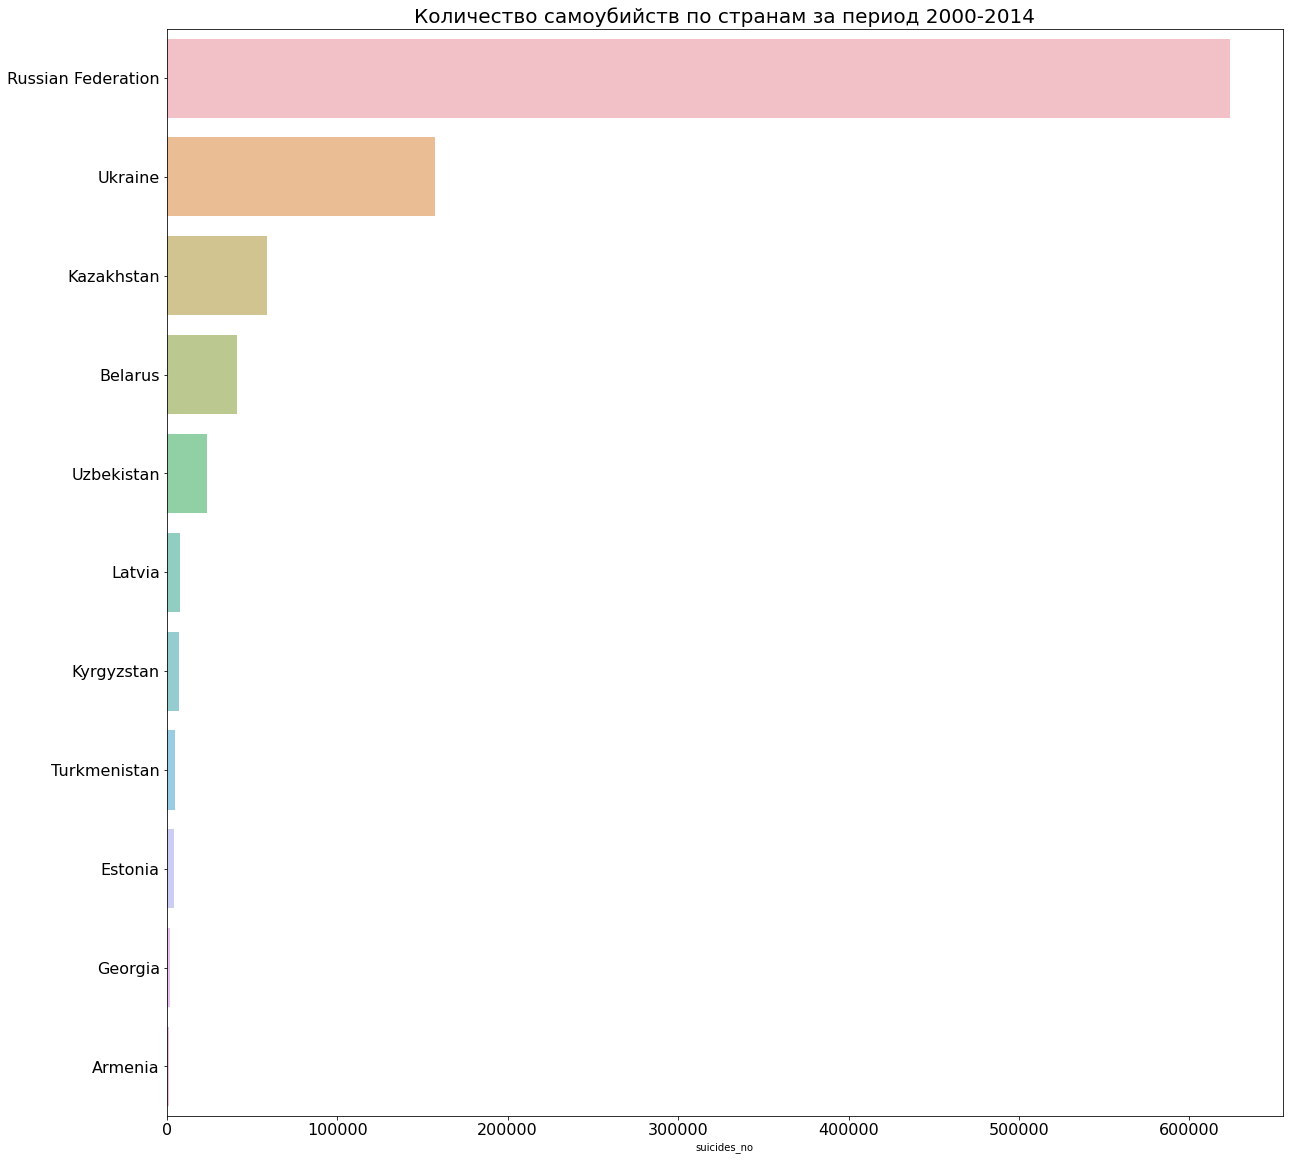

In [60]:
plt.figure(figsize=(20, 20))
plt.title('Количество самоубийств по странам за период 2000-2014', fontsize=20)
plt.tick_params(labelsize=16)
sns.barplot(y=suicide_country.index.values, x=suicide_country, alpha=0.6)
plt.show()

In [61]:
suicide100k_country = df_postUSSR_00_14_upd.groupby('country')['suicides/100k pop'].mean() \
    .sort_values(ascending=False)
suicide100k_country

country
Russian Federation    32.111222
Belarus               30.285750
Kazakhstan            29.580667
Latvia                26.274611
Ukraine               24.632639
Estonia               23.224667
Kyrgyzstan            11.762278
Turkmenistan           7.083889
Uzbekistan             6.528694
Georgia                3.833472
Armenia                3.048167
Name: suicides/100k pop, dtype: float64

Тоже самое, но количество самоубийств на 100к человек, чтобы увидеть где охотнее самоубиваются.

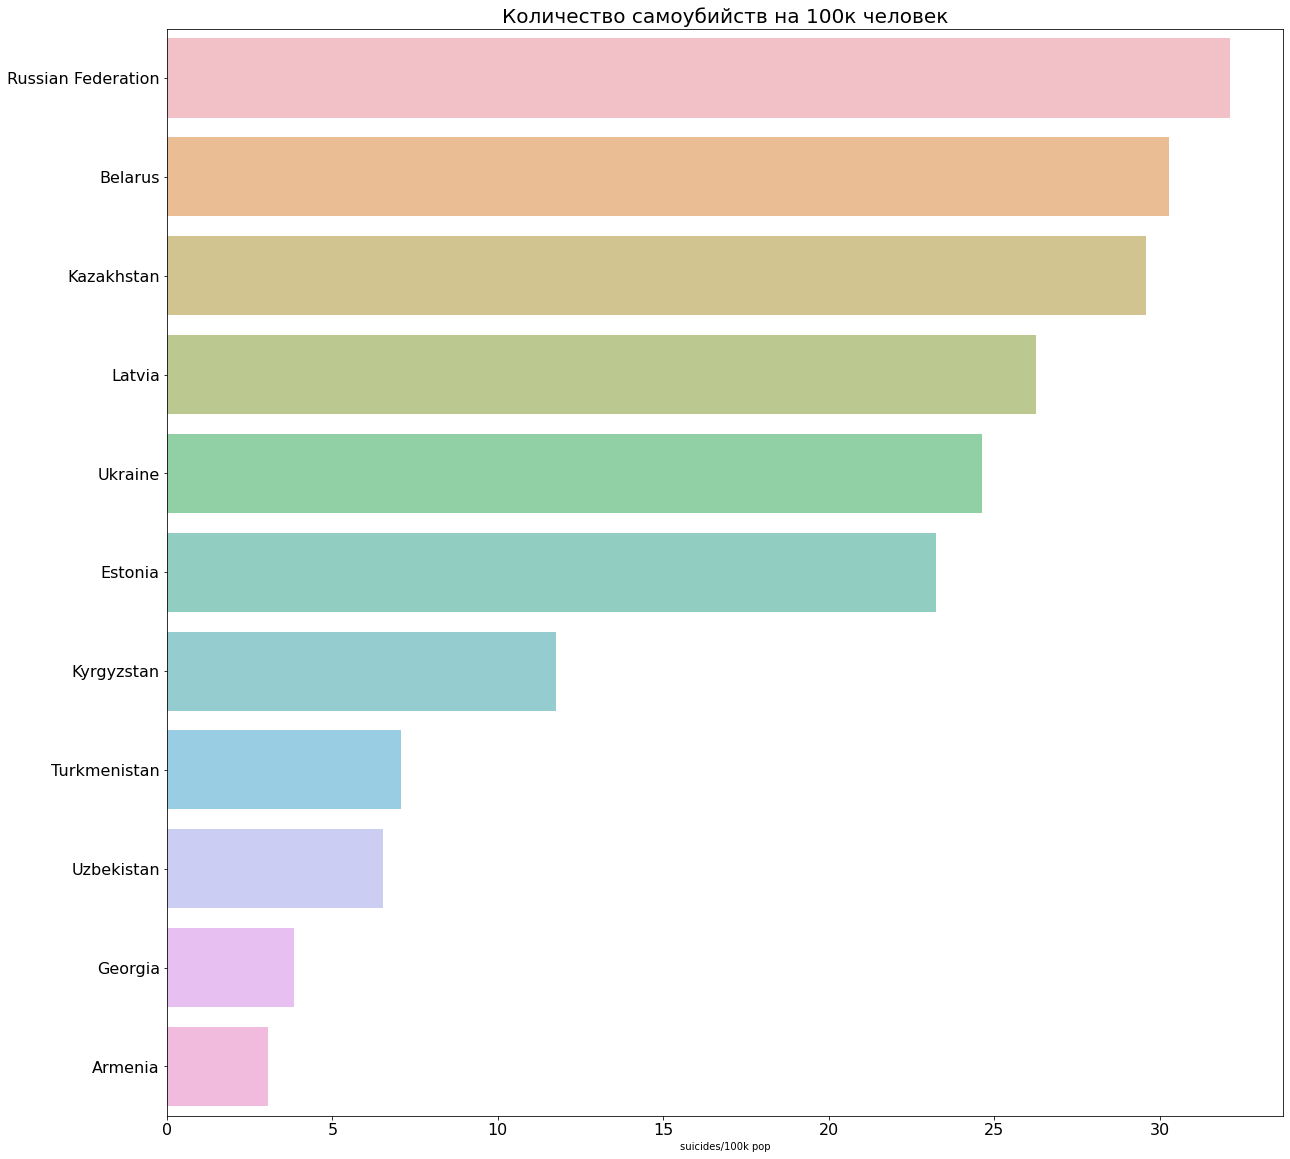

In [62]:
plt.figure(figsize=(20,20))
plt.title('Количество самоубийств на 100к человек', fontsize=20)
plt.tick_params(labelsize=16)
sns.barplot(y=suicide100k_country.index.values, x=suicide100k_country, alpha=0.6)
plt.show()

In [63]:
suicide_percent = df_postUSSR_00_14_upd.groupby('country') \
    .agg({ 'suicides_no': 'sum', 'population': 'sum'})
suicide_percent['percent'] = (suicide_percent['suicides_no'] / suicide_percent['population']) * 100
suicide_percent

,suicides_no,population,percent
country,,,
Armenia,995,44054359,0.002259
Belarus,41066,138239385,0.029706
Estonia,4233,19182356,0.022067
Georgia,1932,61656675,0.003133
Kazakhstan,58596,214939817,0.027262
Kyrgyzstan,7302,70531060,0.010353
Latvia,7949,31206818,0.025472
Russian Federation,623594,2034887977,0.030645
Turkmenistan,4673,65860950,0.007095


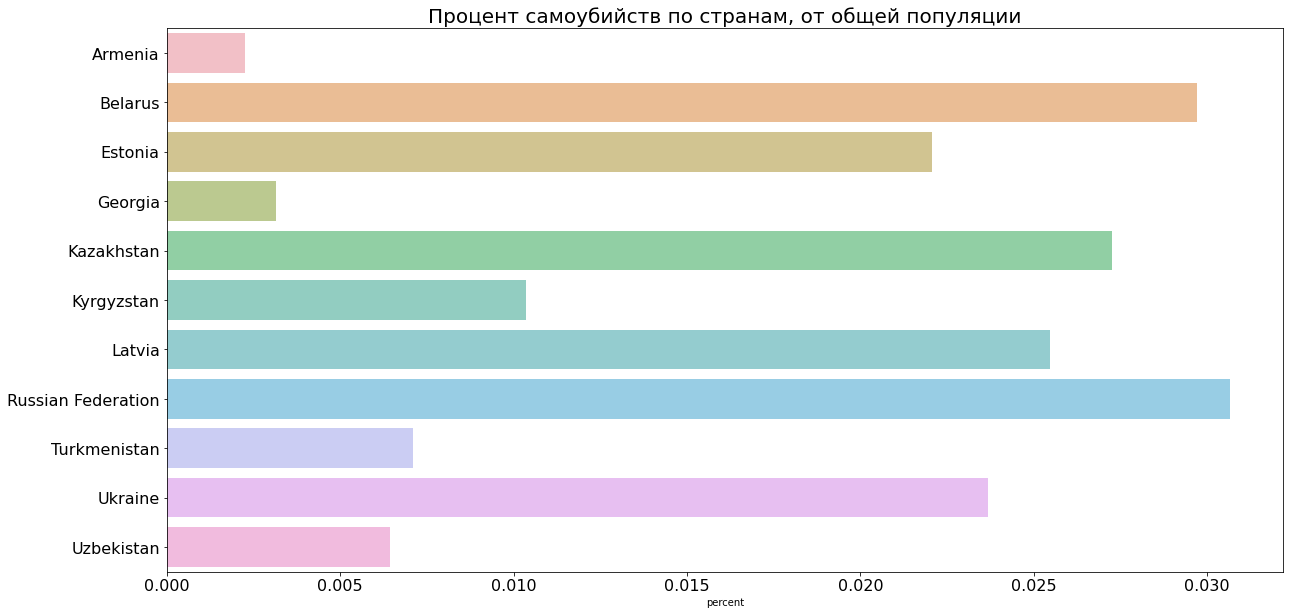

In [64]:
plt.figure(figsize=(20, 10))
plt.title('Процент самоубийств по странам, от общей популяции', fontsize=20)
plt.tick_params(labelsize=16)
sns.barplot(y=suicide_percent.index.values, x=suicide_percent.percent, alpha=0.6)
plt.show()

Смешные цифры, даже 0.1 процента не набралось убыли.

Скаттерплот с распределением самоубийства с зависимостью от HDI

In [65]:
suicide_HDI = df_postUSSR_00_14_upd.groupby('HDI')['suicides/100k pop'].mean().reset_index()
suicide_HDI

,HDI,suicides/100k pop
0,0.593,15.219167
1,0.594,10.025833
2,0.614,13.018000
3,0.625,7.151833
4,0.634,11.072000
...,...,...
58,0.838,20.499833
59,0.849,19.105000
60,0.855,20.134167
61,0.859,19.326667


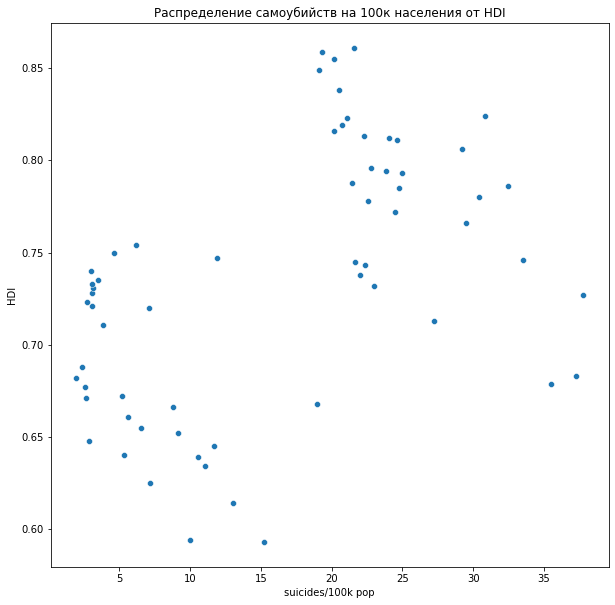

In [66]:
plt.figure(figsize=(10, 10))
plt.title('Распределение самоубийств на 100к населения от HDI')
sns.scatterplot(data=suicide_HDI, x='suicides/100k pop', y='HDI')
plt.show()

Как видно, связи между количеством самоубийств на 100к и HDI - нет

А также можно посмотреть распределение HDI и GDP. (хочца скаттерплот потестить хд)

(Не связано с самоубийствами, ну да ладно)

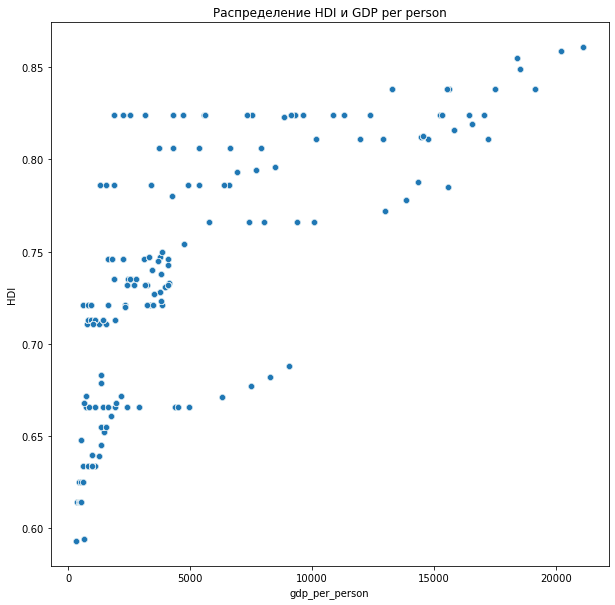

In [67]:
plt.figure(figsize=(10, 10))
plt.title('Распределение HDI и GDP per person')
sns.scatterplot(data=df_postUSSR_00_14_upd, x='gdp_per_person', y='HDI')
plt.show()

Тут связь явная и линейная, чем больше GDP на человека - тем выше HDI в стране. (очевидно хд)

In [68]:
suicide_gdp_per_person = df_postUSSR_00_14_upd.groupby('gdp_per_person')['suicides/100k pop'] \
    .mean().reset_index()
suicide_gdp_per_person

,gdp_per_person,suicides/100k pop
0,313,15.219167
1,345,16.108333
2,359,14.425833
3,424,11.488333
4,428,7.940000
...,...,...
152,18411,20.134167
153,18545,19.105000
154,19141,20.380833
155,20221,19.326667


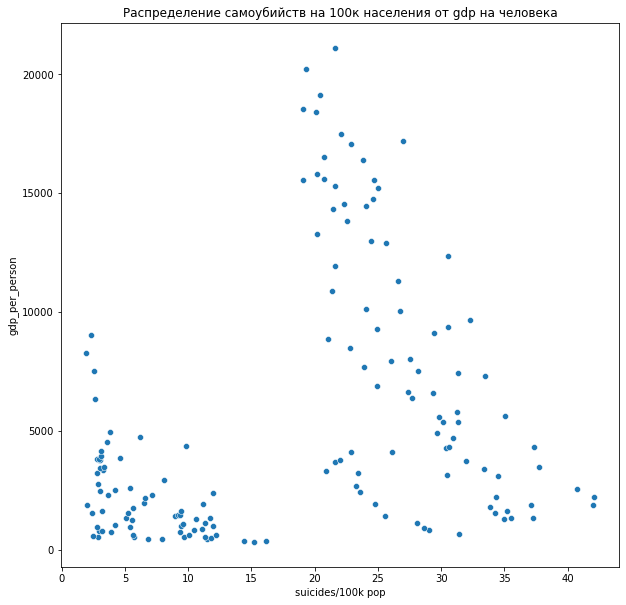

In [69]:
plt.figure(figsize=(10, 10))
plt.title('Распределение самоубийств на 100к населения от gdp на человека')
sns.scatterplot(data=suicide_gdp_per_person, x='suicides/100k pop', y='gdp_per_person')
plt.show()

Связи количества самоубийства на 100к и GDP на человека - нет.

Самовыпил населения по поколениям и странам.

In [70]:
countries = df_postUSSR_00_14_upd.country.unique()
countries

array(['Armenia', 'Belarus', 'Estonia', 'Georgia', 'Kazakhstan',
       'Kyrgyzstan', 'Latvia', 'Russian Federation', 'Turkmenistan',
       'Ukraine', 'Uzbekistan'], dtype=object)

In [71]:
df_country_gen = df_postUSSR_00_14_upd.groupby(['country', 'generation']).suicides_no.sum() \
    .reset_index()
df_country_gen

,country,generation,suicides_no
0,Armenia,Boomers,296
1,Armenia,G.I. Generation,9
2,Armenia,Generation X,205
3,Armenia,Generation Z,10
4,Armenia,Millenials,133
...,...,...,...
61,Uzbekistan,G.I. Generation,31
62,Uzbekistan,Generation X,7177
63,Uzbekistan,Generation Z,485
64,Uzbekistan,Millenials,8819


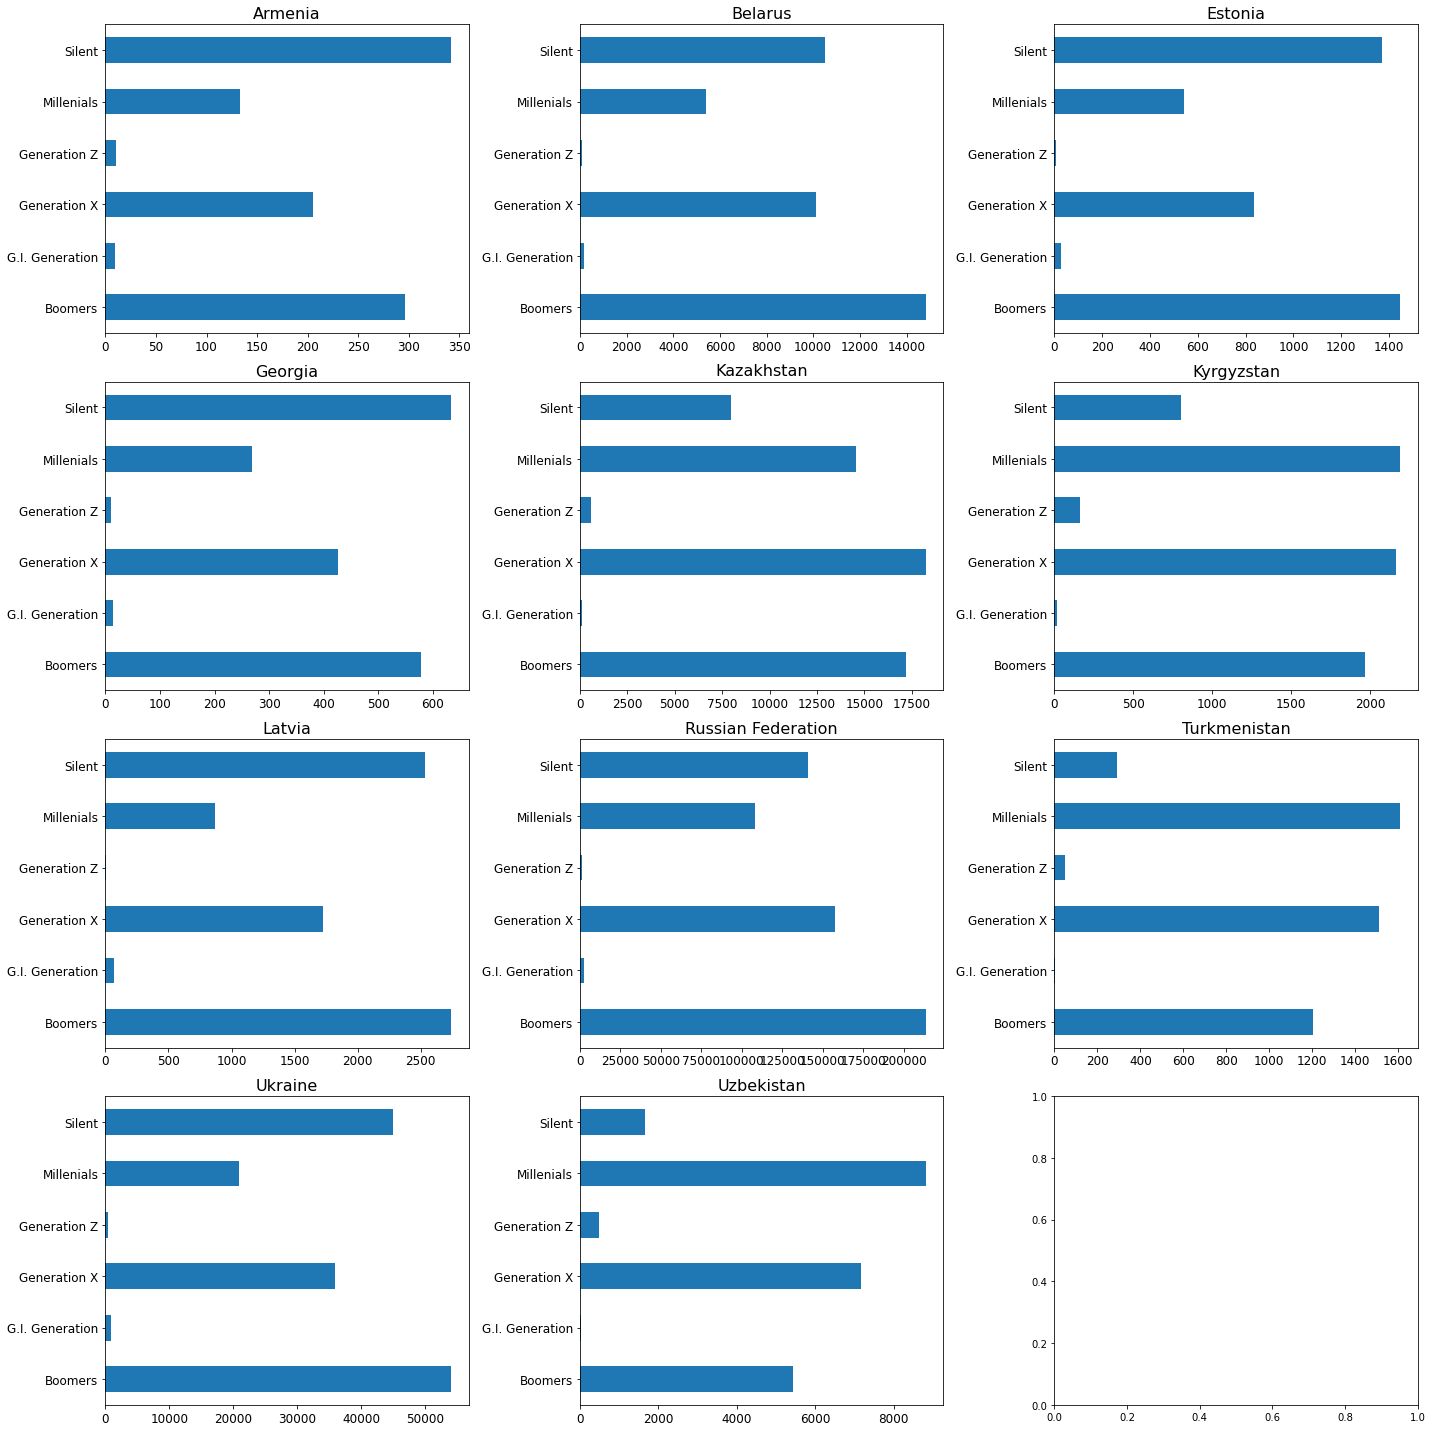

In [72]:
fig, axes = plt.subplots(4, 3, sharex=False, squeeze=False, figsize=(20, 20))

for ax, country in zip(axes.ravel(), countries):
    tmp_df_country = df_country_gen[df_country_gen.country.eq(country)]
    ax.set_title(country, fontsize=16)
    ax.yaxis.label.set_visible(False)
    plt.tight_layout()
    
    tmp_df_country.plot.barh(x='generation', ax=ax, legend=None, fontsize=12)

Все довольно энергично выпиливаются. "Приятно осознавать", что поколение Х, да и Y - ничуть не отстает от бумеров(которых было очень много рождено, на то и бум)

**Изменилось ли соотношение погибших мужского и женского пола в 90х и с 2000х?**

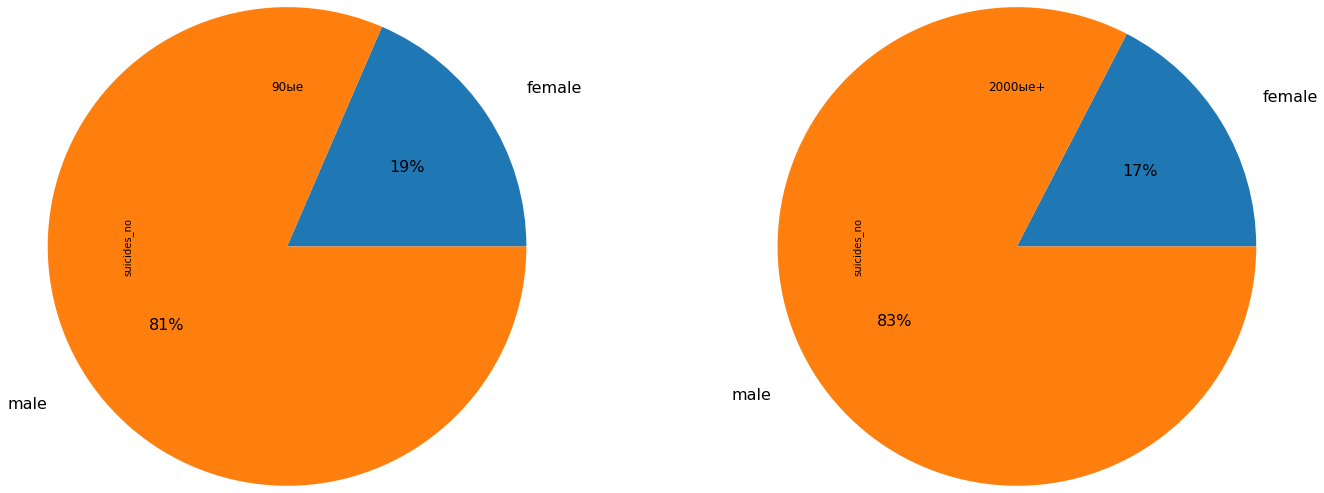

In [73]:
fig, axes = plt.subplots(1, 2, sharex=False, squeeze=False, figsize=(20, 10))

for ax, df_set in zip(axes.ravel(), [df_postUSSR_90_00, df_postUSSR_00_14_upd]):
    tmp_df = df_set.groupby('sex').suicides_no.sum()
    ax.set_title('90ые' if df_set is df_postUSSR_90_00 else '2000ые+')
    plt.tight_layout()
    
    tmp_df.plot.pie(autopct='%1.f%%', radius=2, labeldistance=1.2, fontsize=16, ax=ax)

Только стало хуже :'c

**По миру такая же ситуация?**

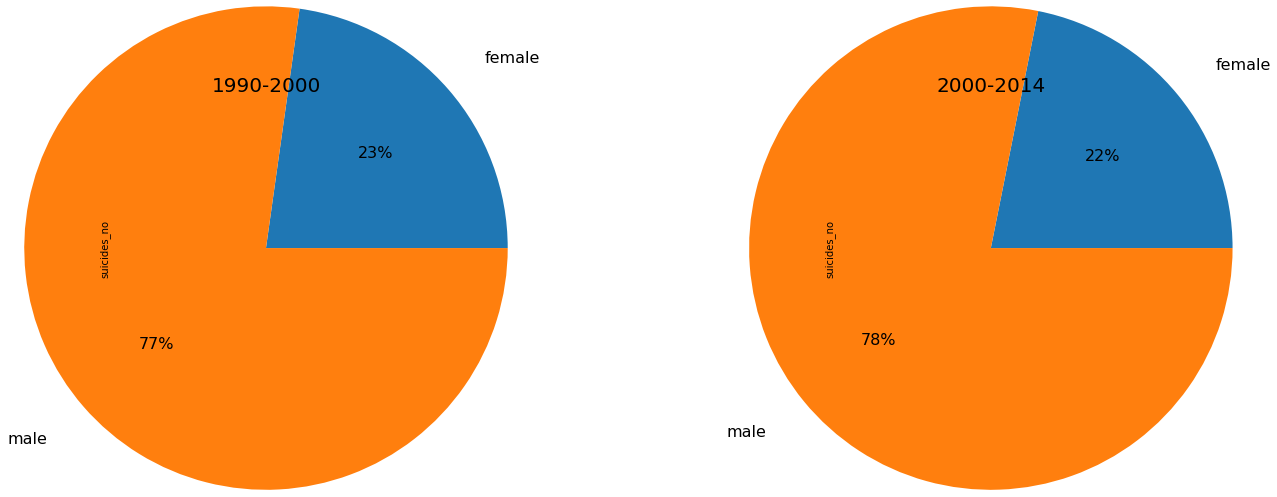

In [74]:
fig, axes = plt.subplots(1, 2, sharex=False, squeeze=False, figsize=(20, 10))

for ax, years_range in zip(axes.ravel(), [(1990, 2000), (2000, 2014)]):
    tmp_df = df[df.year.between(*years_range)].groupby('sex').suicides_no.sum()
    ax.set_title(f'{years_range[0]}-{years_range[1]}', fontsize=20)
    plt.tight_layout()
    
    tmp_df.plot.pie(autopct='%1.f%%', radius=2, labeldistance=1.2, fontsize=16, ax=ax)

В мире ситуация получше, но не намного.

**Страны с наибольшим количеством женских самоубийств? (в процентном соотношении, по убыванию)**

In [75]:
def set_female_suicide_percentage(x):
    total = x['male'] + x['female']
    if total != 0:
        x['female'] = round(x['female'] / total, 3)
    return x

df_suicides_groupped = df.groupby(['country', 'sex']).suicides_no.sum()
df_suicides_groupped = df_suicides_groupped.unstack('sex')
df_suicides_groupped = df_suicides_groupped.astype(float) \
    .apply(set_female_suicide_percentage, axis=1).drop(columns=['male'])
df_suicides_groupped = df_suicides_groupped.sort_values('female', ascending=False)[:10]
df_suicides_groupped

sex,female
country,
Singapore,0.376
Albania,0.352
Netherlands,0.332
Japan,0.312
Kuwait,0.312
Paraguay,0.305
Montenegro,0.305
Ecuador,0.302
Maldives,0.300


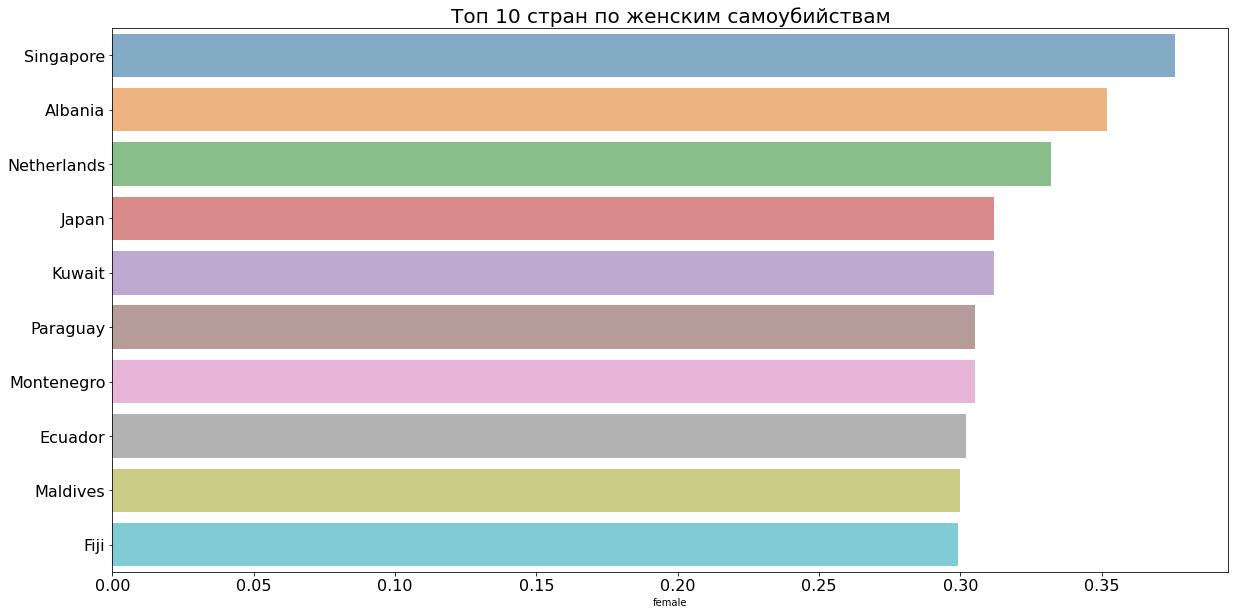

In [76]:
plt.figure(figsize=(20, 10))
plt.title('Топ 10 стран по женским самоубийствам', fontsize=20)
plt.tick_params(labelsize=16)
sns.barplot(y=df_suicides_groupped.index.values, x=df_suicides_groupped.female, alpha=0.6)
plt.show()

**Сравнение числа самоубийств в РФ и США, в 90х**

In [77]:
years = (1990, 1999)
countries = ['Russian Federation', 'United States']
df_usa_rf = df[df.year.between(*years) & (df.country.isin(countries))]
df_usa_rf_agg = df_usa_rf.groupby(['country', 'year']).suicides_no.sum()
df_usa_rf_agg

country             year
Russian Federation  1990    39028
                    1991    39281
                    1992    45923
                    1993    55846
                    1994    61420
                    1995    60548
                    1996    57511
                    1997    54746
                    1998    51518
                    1999    56974
United States       1990    30895
                    1991    30790
                    1992    30471
                    1993    31084
                    1994    31123
                    1995    31272
                    1996    30879
                    1997    30517
                    1998    30558
                    1999    29183
Name: suicides_no, dtype: int64

Диаграмма сравнения самоубийств по РФ и США с 1990 по 2000 года

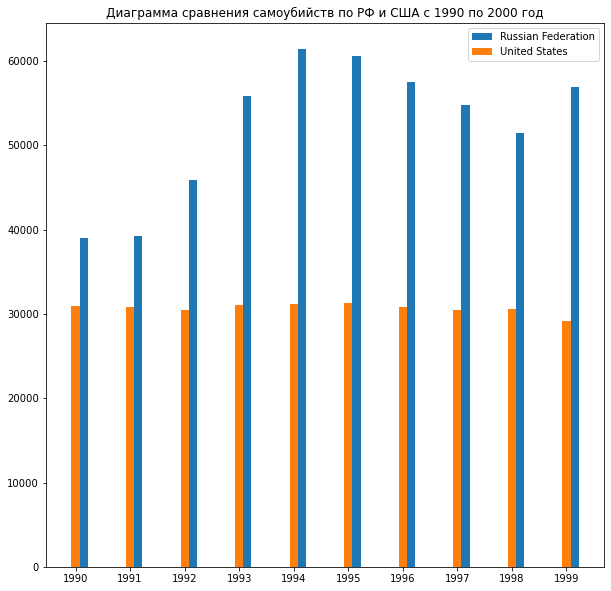

In [78]:
plt.figure(figsize=(10, 10))
# для эмуляции значений x
years_range = np.arange(years[0], years[1] + 1)
x = np.arange(0, len(years_range))
width = 0.15
i = - 1

for country in countries:
    plt.bar(x - i*width, df_usa_rf_agg.loc[country], width, label=country)
    i+=1
plt.title('Диаграмма сравнения самоубийств по РФ и США с 1990 по 2000 год')
plt.xticks(x, years_range)
plt.legend()
plt.show()

И тоже самое, но конкретно для женщин

In [79]:
df_usa_rf_agg = df_usa_rf[df_usa_rf.sex.eq('female')].groupby(['country', 'year']) \
    .suicides_no.sum()
df_usa_rf_agg

country             year
Russian Federation  1990     8742
                    1991     8460
                    1992     9129
                    1993    10096
                    1994    10388
                    1995    10633
                    1996     9685
                    1997     9494
                    1998     8971
                    1999     9909
United States       1990     6179
                    1991     6038
                    1992     6023
                    1993     6092
                    1994     5966
                    1995     5914
                    1996     5899
                    1997     6041
                    1998     6037
                    1999     5741
Name: suicides_no, dtype: int64

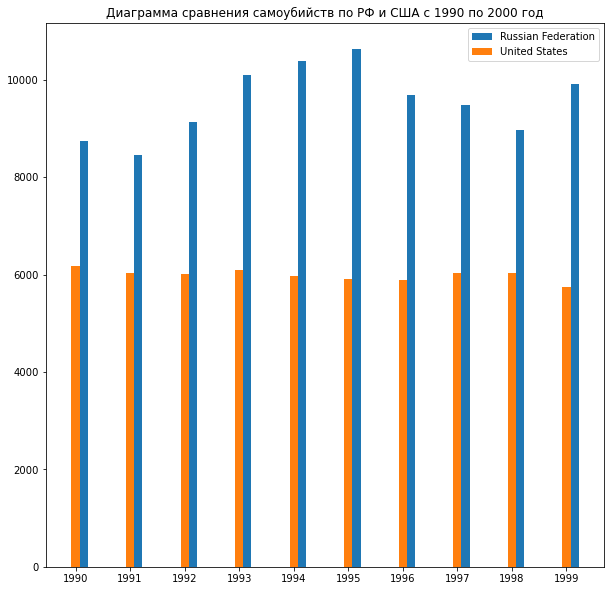

In [80]:
plt.figure(figsize=(10, 10))
# для эмуляции значений x
years_range = np.arange(years[0], years[1] + 1)
x = np.arange(0, len(years_range))
width = 0.15
i = - 1

for country in countries:
    plt.bar(x - i*width, df_usa_rf_agg.loc[country], width, label=country)
    i+=1
plt.title('Диаграмма сравнения самоубийств по РФ и США с 1990 по 2000 год')
plt.xticks(x, years_range)
plt.legend()
plt.show()

Соотношение примерно то же, что и для общего числа самоубийств.

**И сравнение количества самоубийств в США и РФ с 2000 по 2015 годы**

In [81]:
years = (2000, 2015)
countries = ['Russian Federation', 'United States']
df_usa_rf = df[df.year.between(*years) & (df.country.isin(countries))]
df_usa_rf_agg = df_usa_rf.groupby(['country', 'year']).suicides_no.sum()
df_usa_rf_agg

country             year
Russian Federation  2000    56619
                    2001    56958
                    2002    55024
                    2003    51445
                    2004    49096
                    2005    45802
                    2006    42614
                    2007    41149
                    2008    38211
                    2009    37408
                    2010    33356
                    2011    31038
                    2012    29643
                    2013    28690
                    2014    26541
                    2015    25432
United States       2000    29343
                    2001    30607
                    2002    31645
                    2003    31477
                    2004    32428
                    2005    32629
                    2006    33292
                    2007    34596
                    2008    36030
                    2009    36900
                    2010    38362
                    2011    39508
                    201

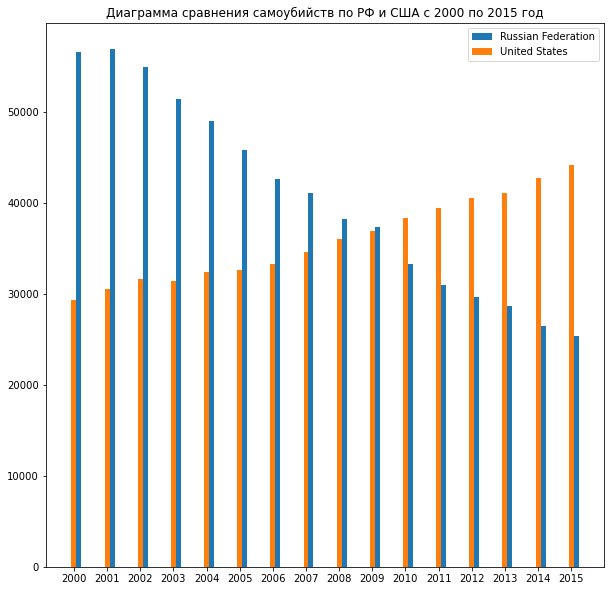

In [82]:
plt.figure(figsize=(10, 10))
# для эмуляции значений x
years_range = np.arange(years[0], years[1] + 1)
x = np.arange(0, len(years_range))
width = 0.15
i = - 1

for country in countries:
    plt.bar(x - i*width, df_usa_rf_agg.loc[country], width, label=country)
    i+=1
plt.title('Диаграмма сравнения самоубийств по РФ и США с 2000 по 2015 год')
plt.xticks(x, years_range)
plt.legend()
plt.show()

**Сравнение самоубийств юных дам с юными же парнями, также в РФ и США**

In [83]:
early_years = ['5-14 years', '15-24 years']
df_usa_rf_agg = df_usa_rf[df_usa_rf.age.isin(early_years)] \
    .groupby(['country', 'sex']).suicides_no.sum()
df_usa_rf_agg

country             sex   
Russian Federation  female    14242
                    male      79065
United States       female    13731
                    male      62157
Name: suicides_no, dtype: int64

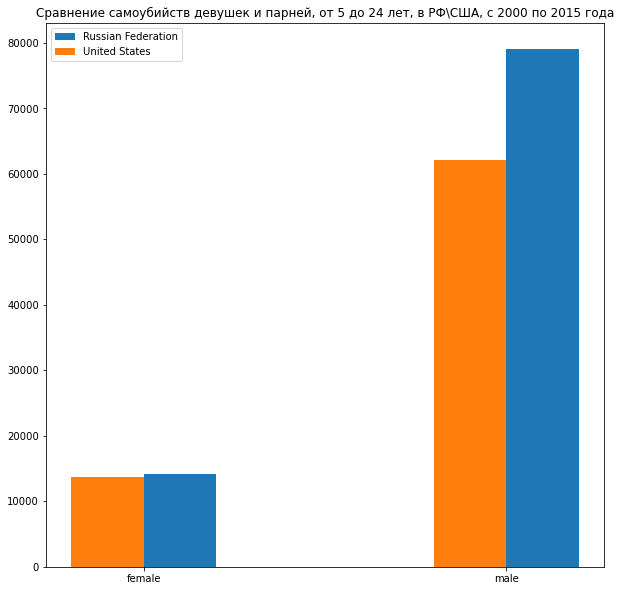

In [84]:
plt.figure(figsize=(10, 10))
# для эмуляции значений x
x = np.array([0, 1])
width = 0.2
i = - 1

for country in countries:
    plt.bar(x - i*width, df_usa_rf_agg.loc[country], width, label=country)
    i+=1
plt.title('Сравнение самоубийств девушек и парней, от 5 до 24 лет, в РФ\США, с 2000 по 2015 года')
# смещение по х на полширины, чтобы черточка градации была посередине колонок
plt.xticks(x + 0.1, ['female', 'male'])
plt.legend()
plt.show()

**Потенциально, я готов переходить к собственно созданию моделей по датасету
Т.е. все интересное из него я вроде как вытащил.**

**Но это не точно**